# Dynamic LCA and Price-Aware Engine for Digital Twin–Based Operation and Control
## Application to KTB1 Continuous Lovastatin Biomanufacturing

**Author**: ADA ROBINSON  
**Date**: 2025-08-19  
**Environment**: `bw25_v3.10_matlab` (Brightway 25 environment with MATLAB engine)  
**Kernel**: `Python 3` (Brightway25 compatible)  
**BW Project**: `dLCA_matlab`  

**Software & Library Versions**  
- Brightway25 version 1.1.0  
- bw2data version 4.5  
- bw2calc version 2.1  
- bw2io version 0.9.11  
- bw2analyzer version 0.11.8  
- bw_temporalis version 1.2.0  
- bw_graph_tools version 0.6  
- matrix_utils version 0.6.2  
- ecoinvent_interface version 3.1  
- numpy version 1.26.4  
- scipy version 1.15.3  
- pandas version 2.3.1  
- matlabengine version 25.1  
- Python version 3.10.18  
- Jupyter core 5.8.1, server 2.16.0, lab 4.4.4  

**Data Sources**:  
- Ecoinvent v3.10 (cut-off system) imported via `ecoinvent_interface`  
- KTB1 model – DTU (https://github.com/Boskabadi/KTB1-DLCA)  
- entsoe – (https://transparency.entsoe.eu/)  

**Notes**: Brightway 2.5 (BW25) is the next-gen framework — meta-package with separated modules (`bw2data`, `bw2io`, etc.).

- Full environment exported to bw25_v3.10_matlab.yml
- Location: C:\Users\arobinson\conda_env_backups\

---

## Project Overview
> **What**: This notebook implements an online-capable dynamic LCA and price-aware scheduling framework for digital twin operation. It couples a continuous-process digital twin in MATLAB/Simulink with Brightway25 and ecoinvent v3.10 (cut-off) to perform hour-resolved dynamic LCA and campaign scheduling: hourly foreground (DI) signals are linked to hourly ENTSO-E generation mixes and day-ahead prices and scored with ReCiPe 2016 v1.03 indicators. The current case study implements the framework for the KTB1 continuous lovastatin biomanufacturing twin. The same structure is applicable to other digital twins. 
>

> **How**:
> 
> Run the notebook “ENTSOE_python_online” once to install and configure the ENTSO-E API client in this environment for real‑time generation and price access.
> Run “Install/Re-install MATLAB Engine” once so matlab.engine works from Python.

1. Import the necessary libraries (i.e. Brightway2.5, bw2io, etc.) and data sources (i.e. Ecoinvent 3.10).
2. Set Project, Import ecoinvent & Select LCA method/s (e.g. ReCiPe 2016)
3. Query the ENTSO-E API for hourly electricity mix generation and day-ahead prices.
4. Start the MATLAB engine and collect hourly foreground data from the digital twin.
5. Map foreground channels and electricity technologies to ecoinvent activities and build per-hour functional Units.
6. Perform dynamic LCA to compute hourly foreground, background, and total system impacts.
7. Optimize annual production/CIP schedules (ENV vs PRICE), and Generate schedule and LCIA/price plots 
8. Generate analysis: orthogonality and sensitivity diagnostics on cost vs LCIA objectives, export databases to Excel for Activity Browser validation, etc.

> **Why**: To turn dynamic LCA into an online environmental KPI that adds a second, independent degree of freedom on top of cost/throughput optimisation. This framework allows to measure an hourly LCIA signal for the plant, shows that this signal is not correlated with electricity price, and exploits that gap to optimise operation further: re-timing PROD/CIP calendars towards “greener” grid hours and enabling control actions based on environmental limits or grid “greenness” thresholds (e.g. slow, pause, or shift production when a chosen LCIA or grid-impact limit is exceeded).


## 1. Libraries Import

In [66]:
# Core scientific
import os, time
from pathlib import Path
from datetime import datetime
import importlib.metadata as md
import numpy as np
import pandas as pd
import seaborn as sns
from numpy.linalg import lstsq

# Plotting and visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator, FuncFormatter
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator
from matplotlib.patches import Patch
import itertools as it

# Utility
from numpy.lib.stride_tricks import sliding_window_view

# Brightway25 modules 
import bw2data as bd
import bw2io as bi
import bw2calc as bc
import bw2analyzer as ba

# Time-explicit/dynamic add-on 
from bw_temporalis.lca import TemporalisLCA
from bw_temporalis.timeline import Timeline
from bw_temporalis.temporal_distribution import TemporalDistribution
import bw_graph_tools as graph

# Versions
print("brightway25 =", md.version("brightway25"))
print("bw2data     =", md.version("bw2data"))
print("bw2calc     =", md.version("bw2calc"))
print("bw2io       =", md.version("bw2io"))
print("bw2analyzer =", md.version("bw2analyzer"))
print("bw_temporalis =", md.version("bw-temporalis"))
print("bw_graph_tools =", md.version("bw-graph-tools"))
print("ecoinvent_interface =", md.version("ecoinvent-interface"))

brightway25 = 1.1.0
bw2data     = 4.5
bw2calc     = 2.1
bw2io       = 0.9.11
bw2analyzer = 0.11.8
bw_temporalis = 1.2.0
bw_graph_tools = 0.6
ecoinvent_interface = 3.1


## 2.1 Brightway Project Set up & Ecoinvent Database Import

In [2]:
#list(bd.projects)

In [3]:
bd.projects.create_project("dLCA_matlab", biosphere="default", default_fp=False)
bd.projects.set_current("dLCA_matlab")
print("Current project:", bd.projects.current)

Current project: dLCA_matlab


In [1]:
#eidb = bi.import_ecoinvent_release(
    version="3.10",
    system_model="cutoff",   # or "consequential", "apos", "EN15804"
    username="XXX",
    password="XXX",
)
print("Imported:", eidb)

IndentationError: unexpected indent (4036120351.py, line 2)

In [5]:
bd.databases

Databases dictionary with 3 object(s):
	ecoinvent-3.10-biosphere
	ecoinvent-3.10-cutoff
	ktb1_ab_validation

In [6]:
#list(bd.databases)

 ## 2.2 LCIA method definition

In [7]:
#list(bd.methods)

In [8]:
#Method Sarch Engine:

matching_methods = [
    m for m in bd.methods
    if "ReCiPe" in str(m)
    and "endpoint (E)" in str(m)
    and "total" in str(m)
    #and "ecosystem quality" in str(m)
]
print(f"Found {len(matching_methods)} matching methods.\n")
for method_tuple in matching_methods:
    print(method_tuple)

Found 6 matching methods.

('ecoinvent-3.10', 'ReCiPe 2016 v1.03, endpoint (E) no LT', 'total: ecosystem quality no LT', 'ecosystem quality no LT')
('ecoinvent-3.10', 'ReCiPe 2016 v1.03, endpoint (E) no LT', 'total: human health no LT', 'human health no LT')
('ecoinvent-3.10', 'ReCiPe 2016 v1.03, endpoint (E) no LT', 'total: natural resources no LT', 'natural resources no LT')
('ecoinvent-3.10', 'ReCiPe 2016 v1.03, endpoint (E)', 'total: ecosystem quality', 'ecosystem quality')
('ecoinvent-3.10', 'ReCiPe 2016 v1.03, endpoint (E)', 'total: human health', 'human health')
('ecoinvent-3.10', 'ReCiPe 2016 v1.03, endpoint (E)', 'total: natural resources', 'natural resources')


### <span style="color:red">LCIA_METHOD_HINT can contain as many methods as you need

In [9]:
#LCIA Method Definition

LCIA_METHOD_HINT = {
    "ecosystem quality": {
        "database": "ecoinvent-3.10",
        "method_name": "ReCiPe 2016 v1.03, endpoint (E)",
        "category": "total: ecosystem quality",
        "description": "ecosystem quality",
        "method_key": None,  # Will be resolved automatically
        "active": True
    }
}

## 3. Initial Declarations 

In [10]:
# Project & methods
PROJECT_NAME     = "dLCA_matlab"
ECO_DB_NAME      = "ecoinvent-3.10-cutoff"
LCIA_METHOD = LCIA_METHOD_HINT

# Horizon & operations
YEAR_HOURS      = 5400    # TEST; full year: 8760 - 6360
CIP_HOURS       = 120     # TEST; full op: 5 * 24
MAX_BLOCK_HOURS = 480     # TEST; full op: 20 * 24

# Policy: capacity scaling (feedback)
ALPHA_GREEN, ALPHA_NEUTRAL, ALPHA_DIRTY = 1.10, 1.00, 0.90
TAU_CLASSIFY    = 0.10          # 10% threshold for green/dirty classification (vs baseline)
GREEN_TOL_PCT   = 0.10          # deadband for runtime feedback (same 10%)

# CIP payload: modeled as wastewater (m3/event) evenly spread across CIP_HOURS
CIP_ENABLED           = True
CIP_LABEL             = "CIP_Wastewater"    # column/key used everywhere
CIP_WW_M3_PER_EVENT   = 125.0               # 125 000 L per CIP event
CIP_START_OFFSET_H    = 0                   # shift first CIP start (hours); 0 = align after first block

# Planning vs control mode 
#MODE = "hybrid"              # "milp" | "feedback" | "hybrid"

# Production target (mass) from analysis
V_BASE_L            = 5000.0   # L
PRODUCTIVITY_MG_L_H = 6.0      # mg/L/h (from your rationale)
PROD_RATE_KGPH_AT_V1 = PRODUCTIVITY_MG_L_H * V_BASE_L / 1e6  # -> 0.030 kg/h

# Choose ONE number of production hours
#PROD_HOURS = 80               # TEST (e.g., 80 h).  FULL YEAR plan: 6360

# Feasibility check for hours under block/CIP in this horizon (single calc)
feasible_prod_hours = (YEAR_HOURS // (MAX_BLOCK_HOURS + CIP_HOURS)) * MAX_BLOCK_HOURS \
                      + min(YEAR_HOURS % (MAX_BLOCK_HOURS + CIP_HOURS), MAX_BLOCK_HOURS)

# Keep you safe: if too large, raise with a clear message
#assert PROD_HOURS <= feasible_prod_hours, \
       #f"PROD_HOURS={PROD_HOURS} exceeds feasible={feasible_prod_hours} for YEAR_HOURS={YEAR_HOURS}, " \
       #f"MAX_BLOCK_HOURS={MAX_BLOCK_HOURS}, CIP_HOURS={CIP_HOURS}. Lower PROD_HOURS."

# Final mass target for MILP on THIS run
#Q_TARGET = PROD_RATE_KGPH_AT_V1 * PROD_HOURS   # kg

## 4.1 ENTSO-E loader → hourly <span style="color:red">Technology</span> BG shares on UTC

### <span style="color:red">BEFORE START: Please check notebook "ENTSOE_python_online"

In [11]:
# Configuration - Time zones
TZ_BG = "Europe/Copenhagen"
TZ_INTERNAL = "UTC"
ENTSOE_CSV = r"C:\Users\XXX.csv"

In [12]:
# Load & clean ENTSO-E data
def load_and_clean_entsoe():
    """Load and clean ENTSO-E data, returning cleaned df and generation column names."""
    assert os.path.exists(ENTSOE_CSV), f"ENTSOE_CSV not found at: {ENTSOE_CSV}"
    print(f"✓ ENTSO-E file found: {os.path.basename(ENTSOE_CSV)}")

    df_raw = pd.read_csv(ENTSOE_CSV, parse_dates=[0])
    df_raw = df_raw.rename(columns={df_raw.columns[0]: "Time_ts"})
    print(f"✓ Raw data loaded: {df_raw.shape[0]} rows, {df_raw.shape[1]} columns")

    gen_cols = [c for c in df_raw.columns if c != "Time_ts"]

    df = df_raw.copy()
    df[gen_cols] = (
        df[gen_cols]
        .replace("n/e", 0)
        .apply(pd.to_numeric, errors="coerce")
        .fillna(0.0)
    )

    df["Sum_elec_prod"] = df[gen_cols].sum(axis=1)

    print(f"✓ Generation columns: {len(gen_cols)}")
    print(f"✓ Negative values present: {(df[gen_cols] < 0).any().any()}")
    print(f"✓ Zero total rows: {(df['Sum_elec_prod'] == 0).sum()}")
    return df, gen_cols

# Run the pipeline
df, gen_cols = load_and_clean_entsoe()
print(df.head(2))

✓ ENTSO-E file found: entsoe_generation_20250822_184419.csv
✓ Raw data loaded: 8736 rows, 10 columns
✓ Generation columns: 9
✓ Negative values present: False
✓ Zero total rows: 8
                    Time_ts  Sum_elec_prod  Biomass  Fossil Gas  \
0 2024-08-10 22:00:00+00:00           2074        7          48   
1 2024-08-10 23:00:00+00:00           2120        7          50   

   Fossil Hard coal  Fossil Oil  Solar  Waste  Wind Offshore  Wind Onshore  
0                78          15      0     15            633           241  
1                79          16      0     15            648           245  


In [13]:
# Build generation & percentage tables
def create_clean_tables(df, gen_cols):
    """Create two clean tables: generation (absolute) and percentages (shares)."""
    DESIRED = [
        "Biomass", "Fossil Gas", "Fossil Hard coal", "Fossil Oil",
        "Solar", "Waste", "Wind Offshore", "Wind Onshore"
    ]

    present_cols = [c for c in DESIRED if c in gen_cols]
    print(f"✓ Present technologies: {len(present_cols)}/{len(DESIRED)}")
    missing = set(DESIRED) - set(present_cols)
    if missing:
        print(f"  Missing: {missing}")

    generation_table = df[["Time_ts", "Sum_elec_prod"] + present_cols].copy()
    generation_table = generation_table.rename(columns={"Time_ts": "timestamp"})

    pct = df[present_cols].div(df["Sum_elec_prod"], axis=0)
    pct = pct.replace([np.inf, -np.inf], np.nan).fillna(0.0)

    pct_cols = [f"{c}_pct" for c in present_cols]
    pct.columns = pct_cols

    percentage_table = pd.concat([df["Time_ts"], pct], axis=1)
    percentage_table = percentage_table.rename(columns={"Time_ts": "timestamp"})

    # Validate: percentages sum ~ 1.0 when production > 0
    row_sums = percentage_table[pct_cols].sum(axis=1)
    pos_mask = df["Sum_elec_prod"] > 0
    max_dev = abs(row_sums[pos_mask] - 1.0).max()

    print(f"✓ Generation table: {generation_table.shape}")
    print(f"✓ Percentage table: {percentage_table.shape}")
    print(f"✓ Max percentage deviation: {max_dev:.6f}")
    return generation_table, percentage_table, present_cols

generation_table, percentage_table, present_cols = create_clean_tables(df, gen_cols)
print(generation_table.head(2))
print(percentage_table.head(2))

✓ Present technologies: 8/8
✓ Generation table: (8736, 10)
✓ Percentage table: (8736, 9)
✓ Max percentage deviation: 0.500000
                  timestamp  Sum_elec_prod  Biomass  Fossil Gas  \
0 2024-08-10 22:00:00+00:00           2074        7          48   
1 2024-08-10 23:00:00+00:00           2120        7          50   

   Fossil Hard coal  Fossil Oil  Solar  Waste  Wind Offshore  Wind Onshore  
0                78          15      0     15            633           241  
1                79          16      0     15            648           245  
                  timestamp  Biomass_pct  Fossil Gas_pct  \
0 2024-08-10 22:00:00+00:00     0.003375        0.023144   
1 2024-08-10 23:00:00+00:00     0.003302        0.023585   

   Fossil Hard coal_pct  Fossil Oil_pct  Solar_pct  Waste_pct  \
0              0.037608        0.007232        0.0   0.007232   
1              0.037264        0.007547        0.0   0.007075   

   Wind Offshore_pct  Wind Onshore_pct  
0           0.305207   

In [14]:
# Timezone conversion to UTC
def convert_to_utc(df, timestamp_col="timestamp"):
    """Convert a DataFrame's timestamp column to UTC and return UTC-indexed copy."""
    ts = pd.to_datetime(df[timestamp_col], errors="coerce")

    # If timestamps are tz-naive, localize to source (Copenhagen), else respect existing tz
    if ts.dt.tz is None:
        ts = ts.dt.tz_localize(TZ_BG, ambiguous="infer", nonexistent="shift_forward")

    ts_utc = ts.dt.tz_convert(TZ_INTERNAL)

    df_utc = df.copy()
    df_utc[timestamp_col] = ts_utc
    df_utc = df_utc.set_index(timestamp_col).sort_index()

    # Drop duplicate instants (keep first)
    if df_utc.index.duplicated().any():
        dup_count = int(df_utc.index.duplicated().sum())
        print(f"  Removed {dup_count} duplicate timestamps")
        df_utc = df_utc[~df_utc.index.duplicated(keep="first")]

    return df_utc

generation_utc = convert_to_utc(generation_table)
percentage_utc = convert_to_utc(percentage_table)
print("✓ UTC index range:", generation_utc.index.min(), "→", generation_utc.index.max())

✓ UTC index range: 2024-08-10 22:00:00+00:00 → 2025-08-09 21:00:00+00:00


In [15]:
# Finalize hourly coverage, fill gaps & validate shares 
def finalize_tables(generation_utc, percentage_utc):
    """Fill missing hours (ffill small gaps) and return final aligned tables."""
    full_idx = pd.date_range(
        generation_utc.index.min(),
        generation_utc.index.max(),
        freq="h",
        tz=TZ_INTERNAL
    )

    missing_hours = full_idx.difference(generation_utc.index)
    print(f"✓ Missing hours to fill: {len(missing_hours)}")

    generation_final = generation_utc.reindex(full_idx).ffill(limit=1)
    percentage_final = percentage_utc.reindex(full_idx).ffill(limit=1)

    pct_sums = percentage_final.filter(like="_pct").sum(axis=1)
    pos_mask_final = generation_final["Sum_elec_prod"] > 0
    max_dev_final = abs(pct_sums[pos_mask_final] - 1.0).max()

    print("✓ Final tables ready:")
    print(f"  Generation: {generation_final.shape}")
    print(f"  Percentage: {percentage_final.shape}")
    print(f"  Max percentage deviation: {max_dev_final:.6f}")
    print(f"  Complete hourly coverage: {len(full_idx)} hours")
    return generation_final, percentage_final

generation_final, percentage_final = finalize_tables(generation_utc, percentage_utc)
#print(generation_final.head(2))
#print(percentage_final.head(2))

✓ Missing hours to fill: 0
✓ Final tables ready:
  Generation: (8736, 9)
  Percentage: (8736, 8)
  Max percentage deviation: 0.500000
  Complete hourly coverage: 8736 hours


## 4.2 ENTSO‑E loader → hourly <span style="color:red">Price</span> BG shares on UTC

In [16]:
# Day-ahead price (EUR/MWh) → UTC hourly series aligned to 'percentage_final'
ENTSOE_PRICE_CSV = r"C:\Users\XXX.csv"

In [17]:
def load_price_to_utc(csv_path, index_ref):
    # Read CSV, first column = timestamp (already tz-aware in your file), second = price
    pr = pd.read_csv(csv_path, parse_dates=[0], index_col=0)
    # Debug to see what we got

    # Ensure numeric price column
    if isinstance(pr, pd.DataFrame):
        if pr.shape[1] == 0:
            raise ValueError("Price CSV has no data columns.")
        # take the first data column explicitly and coerce to numeric
        ser = pd.to_numeric(pr.iloc[:, 0], errors='coerce')
    else:
        # if read_csv returned a Series
        ser = pd.to_numeric(pr, errors='coerce')

    # Ensure DatetimeIndex & timezone handling (don’t re-parse if already tz-aware)
    idx = pr.index
    if not isinstance(idx, pd.DatetimeIndex):
        idx = pd.to_datetime(idx, utc=True, errors="coerce")
    elif idx.tz is None:
        idx = idx.tz_localize(TZ_BG)  # same source tz you used for generation shares
    # move to UTC
    idx = idx.tz_convert(TZ_INTERNAL)

    # Resample hourly and keep as a Series 
    ser.index = idx
    ser = ser.resample('h').mean()
    ser.name = 'DA_price_EUR_MWh'  

    # Align to ENTSO-E mix hours
    out = ser.reindex(index_ref)
    if out.isna().any():
        out = out.ffill(limit=24).bfill(limit=24)

    return out

In [18]:
price_utc = load_price_to_utc(ENTSOE_PRICE_CSV, percentage_final.index)
print("✓ price_utc aligned:", price_utc.index.min(), "→", price_utc.index.max(),
      "| len =", len(price_utc), "| same hours as percentage_final =", len(price_utc)==len(percentage_final))

✓ price_utc aligned: 2024-08-10 22:00:00+00:00 → 2025-08-09 21:00:00+00:00 | len = 8736 | same hours as percentage_final = True


## PLOT 1. Hourly electricity generation mix and day-ahead price in DK2 (flexible dates)

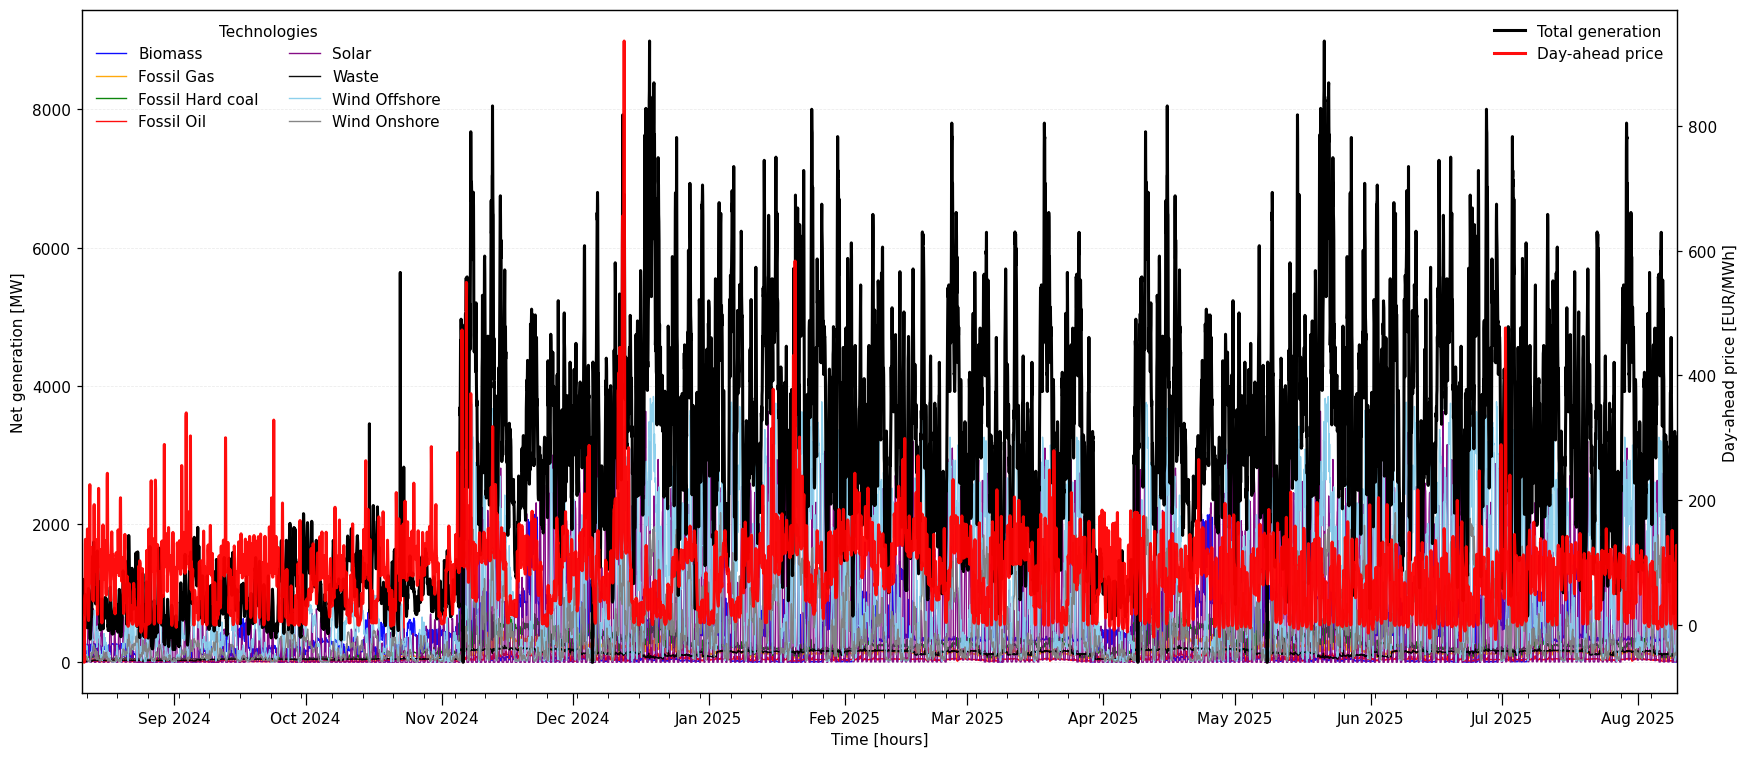

In [19]:
tech_order = [
    c[:-4] for c in percentage_final.columns
    if c.endswith("_pct") and c[:-4] in generation_final.columns
]
assert tech_order, "No matching technology columns found; check column names in your CSV."

# Absolute generation per technology (MW), aligned hourly UTC
G_abs = generation_final[tech_order].apply(pd.to_numeric, errors="coerce").fillna(0.0)

# flexible time window selection
start_date = ""   # first day to include 2024-12-01
end_date   = ""   # last day to include 2025-01-01
# leave both as None to plot full dataset

if start_date and end_date:
    G_abs = G_abs.loc[start_date:end_date]

x = G_abs.index
total_gen = G_abs.sum(axis=1)                      # MW
price_series = price_utc.reindex(x).astype(float)  # EUR/MWh

# 2) Colors 
COLOR_MAP = {
    "Solar": "#800080",           # purple
    "Wind Offshore": "#87CEEB",   # sky blue
    "Wind Onshore": "#808080",    # gray
    "Biomass": "#0000FF",         # blue
    "Fossil Gas": "#FFA500",      # orange
    "Fossil Hard coal": "#008000",# green
    "Fossil Oil": "#FF0000",      # red
    "Waste": "#000000",           # black
}
tech_colors = [COLOR_MAP.get(t, "#bbbbbb") for t in tech_order]
total_color = "black"
price_color = "#FF0000"

# 3) Plot lines 
fig, ax = plt.subplots(figsize=(16, 7), dpi=110)

# Technology lines (left axis, MW)
tech_lines = []
for t, col in zip(tech_order, tech_colors):
    ln, = ax.plot(x, G_abs[t].values, color=col, linewidth=0.9, alpha=0.95, label=t)
    tech_lines.append(ln)

# Total generation (MW) — black line
tot_line, = ax.plot(x, total_gen.values, color=total_color, linewidth=2.0, label="Total generation")

# Price (EUR/MWh) — right axis
ax2 = ax.twinx()
price_line, = ax2.plot(x, price_series.values, color=price_color, linewidth=2.0, alpha=0.95, label="Day-ahead price")

# 4) Axis formatting 
ax.set_xlim([x.min(), x.max()])
ax.set_ylabel("Net generation [MW]")
ax.set_xlabel("Time [hours]")   
ax2.set_ylabel("Day-ahead price [EUR/MWh]")

# Bottom axis: monthly majors + weekly minors
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax.xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=1))
ax.tick_params(axis="x", which="major", length=8)
ax.tick_params(axis="x", which="minor", length=3)

# Top axis: months (calendar scale)
#ax_top = ax.twiny()
#ax_top.set_xlim(ax.get_xlim())
#ax_top.xaxis.set_major_locator(mdates.MonthLocator())
#ax_top.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
#ax_top.set_xlabel("Months")

# Grid and margins
ax.grid(True, axis="y", alpha=0.25, linestyle="--", linewidth=0.5)
ax.margins(x=0)

# 5) Legends
leg_left  = ax.legend(handles=tech_lines, title="Technologies", loc="upper left", ncol=2, frameon=False)
leg_right = ax.legend(handles=[tot_line, price_line], loc="upper right", frameon=False)
ax.add_artist(leg_left)  # keep first legend when adding the second

# 6) SAVE
save_path = r"C:\Users\XXX.png"
plt.savefig(save_path, dpi=600, bbox_inches="tight")

# 7) Show
plt.tight_layout()
plt.show()

Figure X. Figure 2. DK2 background signals used in this case study explain when and how electricity is generated and priced. (a) 01 Dec 2024–01 Jan 2025; (b) 15 Mar – 15 Apr 2025. Hourly net generation by technology (MWh, left axis) with biomass blue, fossil gas orange, hard coal green, oil red, waste purple, solar yellow, wind offshore light-blue, wind onshore grey; total generation black. Day-ahead price (EUR MWh, right axis) shown in red.

## 5. Matlab engine → hourly FG sampler (online)

### <span style="color:red">BEFORE START: Please check notebook "Install/Re-install MATLAB Engine"

In [20]:
# Start MATLAB & load model
# If you encounter difficulties, see notebook "Install/Re-install MATLAB Engine"
import matlab.engine

eng = matlab.engine.start_matlab()
eng.load_system('XXX', nargout=0)

print("✓ MATLAB engine started and model loaded.")

✓ MATLAB engine started and model loaded.


In [21]:
start_time = time.time()

target_unique = int(MAX_BLOCK_HOURS) + 1  # need H+1 points for H intervals
seen_hours   = set()
time_data    = []
value_data   = []

last_t = None
max_wall_sec =  1500  # hard safety stop!!!!
polls        = 0

print(f"Sampling DI… target unique hours = {target_unique}")

while len(seen_hours) < target_unique:
    # simple wall‑clock guard
    if (time.time() - start_time) > max_wall_sec:
        raise TimeoutError(f"DI sampling exceeded {max_wall_sec} s without reaching "
                           f"{target_unique} unique hours (got {len(seen_hours)}).")

    t, val = eng.step_and_get_DI(nargout=2)  # MATLAB returns integer hour, + vector of 13 values
    t = int(t)
    arr = np.asarray(val, dtype=float).ravel().tolist()

    if last_t is not None and t < last_t:
        # Non‑monotonic tick (rare). Skip and keep stepping.
        print(f"↪ non‑monotonic tick {t} < last {last_t} — skipping")
        continue

    if t not in seen_hours:
        seen_hours.add(t)
        time_data.append(t)
        value_data.append(arr)
        print(f"Hour {t}: captured ({len(seen_hours)}/{target_unique}) — {len(arr)} values")
    else:
        # Duplicate tick from engine — skip
        print(f"Hour {t}: duplicate — skipped")

    last_t = t
    polls  += 1

end_time = time.time()
print(f"\n⏱ DI sampling finished in {end_time - start_time:.2f} seconds")
print(f"✓ Captured {len(seen_hours)} unique hours "
      f"({min(time_data)} → {max(time_data)}) in {polls} engine polls.")

Sampling DI… target unique hours = 481
Hour 1: captured (1/481) — 13 values
Hour 2: captured (2/481) — 13 values
Hour 3: captured (3/481) — 13 values
Hour 4: captured (4/481) — 13 values
Hour 5: captured (5/481) — 13 values
Hour 10: captured (6/481) — 13 values
Hour 12: captured (7/481) — 13 values
Hour 13: captured (8/481) — 13 values
Hour 14: captured (9/481) — 13 values
Hour 15: captured (10/481) — 13 values
Hour 16: captured (11/481) — 13 values
Hour 17: captured (12/481) — 13 values
Hour 21: captured (13/481) — 13 values
Hour 24: captured (14/481) — 13 values
Hour 25: captured (15/481) — 13 values
Hour 26: captured (16/481) — 13 values
Hour 27: captured (17/481) — 13 values
Hour 28: captured (18/481) — 13 values
Hour 30: captured (19/481) — 13 values
Hour 36: captured (20/481) — 13 values
Hour 37: captured (21/481) — 13 values
Hour 38: captured (22/481) — 13 values
Hour 39: captured (23/481) — 13 values
Hour 40: captured (24/481) — 13 values
Hour 41: captured (25/481) — 13 values


In [51]:
# DataFrame, one row per unique hour
df_raw = pd.DataFrame(value_data)
df_raw.insert(0, "Time", time_data)
df_raw = df_raw.sort_values("Time").drop_duplicates(subset=["Time"], keep="last").reset_index(drop=True)

column_names = [
    "Time",           # integer hour tick
    "M_lac",          # Media lactate flow [g/h]
    "M_Ad",           # Media acetate flow [g/h]
    "M_Lov",          # Media lovastatin flow [g/h]
    "Biomass_Purge",  # Biomass purge stream [g/h]
    "Lac_purge",      # Lactate purge [L/h]
    "Ad_Purge",       # Acetate purge [L/h]
    "Lov_purge",      # Lovastatin purge [L/h]
    "HC_Energy",      # Hydrocyclone energy [W]
    "Reactor_Energy",
    "Centrifuge_Energy",
    "VSP_Energy",     # Vibratory screen pump energy [W]
    "WaterMakeup",
    "Wastewater"
]

if len(column_names) != df_raw.shape[1]:
    raise ValueError(f"Mismatch: got {df_raw.shape[1]} columns in DI, expected {len(column_names)}.\n"
                     f"First row example: {df_raw.iloc[0].to_list()}")

df_raw.columns = column_names

# Sanity check
expected_rows = int(MAX_BLOCK_HOURS) + 1
assert len(df_raw) == expected_rows, (
    f"DI block length is {len(df_raw)} rows; expected {expected_rows} "
    f"(check step_and_get_DI or extend sampling time)."
)

print("✓ Data collected at integer hours (ascending, unique):")
print(df_raw.head(3))
print(f"✓ DI block captured: {len(df_raw)} rows; last Time = {df_raw['Time'].max()}")

✓ Data collected at integer hours (ascending, unique):
   Time       M_lac        M_Ad      M_Lov  Biomass_Purge   Lac_purge  \
0     1  682.839659  136.567932  29.253226    1104.067577  149.150240   
1     2  685.451534  137.090307  29.193298    1107.805876  150.116270   
2     3  686.227806  137.245561  29.176527    1111.226875  150.762545   

    Ad_Purge  Lov_purge  HC_Energy  Reactor_Energy  Centrifuge_Energy  \
0  25.334409  12.089313   1.163240       19.806252          13.628857   
1  25.498987  12.171777   1.633780       20.004968          13.628883   
2  25.609308  12.228924   2.028008       20.055595          13.628913   

   VSP_Energy  WaterMakeup  Wastewater  
0    5.756660    41.285888   32.178352  
1    5.777739    47.745841   32.376094  
2    5.791801    53.098619   32.493113  
✓ DI block captured: 481 rows; last Time = 947


In [52]:
# Quick integrity check
EQUIP = ["HC_Energy","Reactor_Energy","Centrifuge_Energy","VSP_Energy"]
assert set(EQUIP).issubset(df_raw.columns), "Missing energy columns from MATLAB DI."

# Energy should be non‑negative (W)
neg_pwr = (df_raw[EQUIP] < 0).any().any()
print("Foreground power any negative? ->", neg_pwr)
assert not neg_pwr, "Some power signals are negative; fix sign/units in MATLAB."

# Full preview of the DI block 
print("\n— Full DI block (Time + energy) —")
print(df_raw[["Time"] + EQUIP].head(int(MAX_BLOCK_HOURS) + 1))

Foreground power any negative? -> False

— Full DI block (Time + energy) —
     Time  HC_Energy  Reactor_Energy  Centrifuge_Energy  VSP_Energy
0       1   1.163240       19.806252          13.628857    5.756660
1       2   1.633780       20.004968          13.628883    5.777739
2       3   2.028008       20.055595          13.628913    5.791801
3       4   2.066407       20.059938          13.628948    5.805236
4       5   2.066816       20.059949          13.628978    5.816294
..    ...        ...             ...                ...         ...
476   938   2.164905       20.059937          13.628699    5.710675
477   939   2.164885       20.059937          13.628699    5.710530
478   940   2.164866       20.059937          13.628699    5.710395
479   942   2.164811       20.059937          13.628700    5.709996
480   947   2.164711       20.059937          13.628701    5.709276

[481 rows x 5 columns]


 ## 6. Ecoinvent Mapping (BG Energy + FG Feedstock + CIP WWTP)

In [53]:
# FILTER & FIND ENERGY-related activities in 'ecoinvent-3.10-cutoff' 

cutoff_db = bd.Database("ecoinvent-3.10-cutoff")
#filtered_acts = [
    act
    for act in cutoff_db
    if (
        ("electricity" in act["name"].lower() or "heat" in act["name"].lower())
        and "DK" in act["location"]  # Change to act["location"] == "DK" if you need an exact match
    )
]

print(f"Found {len(filtered_acts)} matching activities.\n")
for act in filtered_acts:
    print(f"- {act['name']} | Location: {act['location']} | Ref Product: {act.get('reference product')}")

IndentationError: unexpected indent (2689746049.py, line 5)

In [54]:
# FILTER & FIND MASS-related activities in 'ecoinvent-3.10-cutoff' 

cutoff_db = bd.Database("ecoinvent-3.10-cutoff")
#filtered_acts = [
    act
    for act in cutoff_db
    if (
        ("aminopyridine" in act["name"].lower() or "spray-drying" in act["name"].lower() or "yeast" in act["name"].lower() or "ultrapure" in act["name"] or "fodder" in act["name"])
        #and "DK" in act["location"]  # Change to act["location"] == "DK" if you need an exact match
    )
]

print(f"Found {len(filtered_acts)} matching activities.\n")
for act in filtered_acts:
    print(f"- {act['name']} | Location: {act['location']} | Ref Product: {act.get('reference product')}")

IndentationError: unexpected indent (405902160.py, line 5)

In [55]:
# ELECTRICITY production datasets (kWh)
BG_MAP = {
    "Fossil Hard coal_pct": ("ecoinvent-3.10-cutoff", "electricity production, hard coal"),
    "Fossil Oil_pct":       ("ecoinvent-3.10-cutoff", "electricity production, oil"),
    "Fossil Gas_pct":       ("ecoinvent-3.10-cutoff", "electricity production, natural gas, combined cycle"),
    "Wind Offshore_pct":    ("ecoinvent-3.10-cutoff", "electricity production, wind, 1-3MW turbine, offshore"),
    "Wind Onshore_pct":     ("ecoinvent-3.10-cutoff", "electricity production, wind, 1-3MW turbine, onshore"),
    "Biomass_pct":          ("ecoinvent-3.10-cutoff", "electricity production, biogas, gas engine"),
    "Waste_pct":            ("ecoinvent-3.10-cutoff", "electricity, from municipal waste incineration to generic market for electricity, medium voltage"),
    "Solar_pct":            ("ecoinvent-3.10-cutoff", "electricity production, photovoltaic, 3kWp slanted-roof installation, single-Si, panel, mounted"),
     # Add Danish average electricity mix
    "DK_Average":           ("ecoinvent-3.10-cutoff", "electricity, high voltage, import from DE"),
}

# FEEDSTOCK consumption datasets
FG_MAP = {
    "M_Lac":         ("ecoinvent-3.10-cutoff", "market for spray-drying of milk"),  # lactose proxy
    "M_Ad":          ("ecoinvent-3.10-cutoff", "market for aminopyridine"),         # adenine proxy
    "M_Lov":         None,  # product
    "Biomass_Purge": ("ecoinvent-3.10-cutoff", "fodder yeast to generic market for protein feed"),
    "Lac_Purge":     ("ecoinvent-3.10-cutoff", "fodder yeast to generic market for protein feed"),
    "Ad_Purge":      ("ecoinvent-3.10-cutoff", "fodder yeast to generic market for protein feed"),
    "Lov_Purge":     ("ecoinvent-3.10-cutoff", "fodder yeast to generic market for protein feed"),
    "Wastewater":    ("ecoinvent-3.10-cutoff", "market for water, ultrapure"),
    "WaterMakeup":   ("ecoinvent-3.10-cutoff", "market for water, deionised"),
    # CIP modeled as wastewater treatment (same inventory as 'Wastewater'):
    "CIP_Wastewater": ("ecoinvent-3.10-cutoff", "market for water, ultrapure"),
}

In [56]:
# LOCATION priority (prefer DK when available; then European/regional; then global)
LOC_PRIORITY = ["DK", "DK-1", "DK-2", "Europe without Switzerland", "RER", "CH", "GLO", "RoW"]

# Pick best hit by NAME MATCH, ref product/unit = electricity when BG, and location priority.
def _to_key(hit):
    if isinstance(hit, tuple) and isinstance(hit[0], tuple) and len(hit[0]) == 2:
        return hit[0]
    if isinstance(hit, tuple) and len(hit) >= 2 and all(isinstance(x, str) for x in hit[:2]):
        return (hit[0], hit[1])
    return hit

def _score_activity(act, desired_name, prefer_electricity=False):
    name_ok = 0 if act.get('name','') == desired_name else 1
    loc = act.get('location','GLO')
    try:
        loc_rank = LOC_PRIORITY.index(loc)
    except ValueError:
        loc_rank = 999
    # Electricity preference: ref product/unit typical of kWh electricity
    elec_penalty = 0
    if prefer_electricity:
        rp = (act.get('reference product') or "").lower()
        unit = (act.get('unit') or "").lower()
        # prefer high-/medium-voltage electricity in kWh
        if ("electricity" not in rp) or ("kilowatt hour" not in unit):
            elec_penalty = 10
    return (name_ok, elec_penalty, loc_rank)

def resolve_mapping(map_dict, prefer_elec=False):
    out = {}
    for label, spec in map_dict.items():
        if spec is None:
            continue
        db_name, act_name = spec
        hits = list(bd.Database(db_name).search(act_name, limit=50))
        if not hits:
            raise LookupError(f"No hits for '{act_name}' in {db_name}")
        best = None
        for h in hits:
            try:
                act = bd.get_activity(_to_key(h))
            except Exception:
                continue
            score = _score_activity(act, act_name, prefer_electricity=prefer_elec)
            if (best is None) or (score < best[0]):
                best = (score, act.key)
        if best is None:
            raise LookupError(f"Could not resolve a suitable activity for '{act_name}'")
        out[label] = best[1]
    return out

# Resolve both maps
BG_ACT = resolve_mapping(BG_MAP, prefer_elec=True)
FG_ACT = resolve_mapping(FG_MAP, prefer_elec=False)

print("Resolved BG cols:", list(BG_ACT.keys()))
print("Resolved FG cols:", list(FG_ACT.keys()))

# CIP info in Initial Declarations!!
print(f"CIP enabled={CIP_ENABLED}; event={CIP_WW_M3_PER_EVENT} m3; "
      f"spread={CIP_HOURS} h; label='{CIP_LABEL}'; offset={CIP_START_OFFSET_H} h.")

Resolved BG cols: ['Fossil Hard coal_pct', 'Fossil Oil_pct', 'Fossil Gas_pct', 'Wind Offshore_pct', 'Wind Onshore_pct', 'Biomass_pct', 'Waste_pct', 'Solar_pct', 'DK_Average']
Resolved FG cols: ['M_Lac', 'M_Ad', 'Biomass_Purge', 'Lac_Purge', 'Ad_Purge', 'Lov_Purge', 'Wastewater', 'WaterMakeup', 'CIP_Wastewater']
CIP enabled=True; event=125.0 m3; spread=120 h; label='CIP_Wastewater'; offset=0 h.


## MAPPING TEST
- Print BG mappings (name | ref product | unit | location),
- Assert BG are truly electricity/kWh,
- Print a small FG subset.

In [57]:
def _describe_act(key):
    act = bd.get_activity(key)
    return (key, act['name'], act.get('reference product',''),
            act.get('unit',''), act.get('location',''))

print("BG mappings (key | name | ref prod | unit | loc):")
#for k, akey in BG_ACT.items():
    k_out, n, rp, u, loc = _describe_act(akey)
    print(f"  {k:24s} -> {k_out} | {n} | {rp} | {u} | {loc}")
    assert "electricity" in (rp or "").lower(), f"{k} not electricity RP"
    assert (u or "").lower() == "kilowatt hour", f"{k} unit not kWh"

print("\nFG mappings (key | name | ref prod | unit | loc):")
fg_missing = []
#for lbl in FG_MAP.keys():
    akey = FG_ACT.get(lbl)
    if akey:
        k_out, n, rp, u, loc = _describe_act(akey)
        print(f"  {lbl:16s} -> {k_out} | {n} | {rp} | {u} | {loc}")
    else:
        fg_missing.append(lbl)

if fg_missing:
    print("\n⚠️ Unresolved / None in FG:", fg_missing)

IndentationError: unexpected indent (3656439581.py, line 8)

In [58]:
# FG unit sanity
EXPECTED_FG_UNITS = {
    "M_Lac": "kilogram",
    "M_Ad": "kilogram",
    "Biomass_Purge": "kilogram",   # or "cubic meter" if that's your intent
    "Lac_Purge": "kilogram",
    "Ad_Purge": "kilogram",
    "Lov_Purge": "kilogram",
    "WaterMakeup": "kilogram",     # ecoinvent water, deionised is 'kilogram'
    "Wastewater": "cubic meter",
    "CIP_Wastewater": "cubic meter",
}

def check_fg_units():
    problems = []
    for lbl, key in FG_ACT.items():
        if key is None:
            continue
        act = bd.get_activity(key)
        u = (act.get('unit') or '').lower()
        exp = (EXPECTED_FG_UNITS.get(lbl) or '').lower()
        if exp and u != exp:
            problems.append((lbl, act['name'], u, exp))
    if problems:
        print("⚠️ FG unit mismatches:")
        for p in problems:
            print(f"  - {p[0]} -> '{p[1]}' has unit '{p[2]}', expected '{p[3]}'")
    else:
        print("✅ All mapped FG units match expectations.")

check_fg_units()

⚠️ FG unit mismatches:
  - Wastewater -> 'market for water, ultrapure' has unit 'kilogram', expected 'cubic meter'
  - CIP_Wastewater -> 'market for water, ultrapure' has unit 'kilogram', expected 'cubic meter'


 ## 7. BRIGHTWAY IMPLEMENTATION: Resolve Methods

In [59]:
#Finds the LCIA total and stores  in LCIA_METHODS_RESOLVED.

if 'LCIA_METHOD' not in globals():
    LCIA_METHOD = LCIA_METHOD_HINT  # fallback only if not defined above

def resolve_lcia_methods():
    """Resolve the LCIA endpoint totals you selected in LCIA_METHOD_HINT."""
    resolved = {}
    for method_key, info in LCIA_METHOD.items():
        if not info.get("active", True):
            continue
        name_hint = str(info.get("method_name", "")).lower()
        cat_hint  = str(info.get("category", "")).lower()
        # pick first method matching both substrings
        candidates = [m for m in bd.methods if name_hint in str(m).lower() and cat_hint in str(m).lower()]
        if candidates:
            resolved[method_key] = candidates[0]
            print(f"✅ Resolved {method_key}: {candidates[0]}")
        else:
            print(f"⚠️ No LCIA match for {method_key} ({info.get('method_name')} | {info.get('category')})")
    return resolved

LCIA_METHODS_RESOLVED = resolve_lcia_methods()
print(f"✅ Using {len(LCIA_METHODS_RESOLVED)} resolved LCIA methods")

✅ Resolved ecosystem quality: ('ecoinvent-3.10', 'ReCiPe 2016 v1.03, endpoint (E) no LT', 'total: ecosystem quality no LT', 'ecosystem quality no LT')
✅ Using 1 resolved LCIA methods


 ## 7.1 - Background LCIA intensity (per kWh) over the full ENTSO‑E year

In [60]:
# Safety check
req = ['percentage_final', 'BG_ACT', 'LCIA_METHODS_RESOLVED']
missing = [x for x in req if x not in globals()]
assert not missing, f"Run earlier sections first; missing: {missing}"
assert len(LCIA_METHODS_RESOLVED) > 0, "No LCIA methods resolved in 7.1."

# 1) ENTSO‑E tech share columns 
TECH_SHARE_COLS = [c for c in percentage_final.columns if c.endswith('_pct') and c in BG_ACT]
if not TECH_SHARE_COLS:
    raise RuntimeError("No overlap between ENTSO‑E share columns and BG_ACT labels.")

print(f"✓ 7.1.b: Using {len(TECH_SHARE_COLS)} ENTSO‑E technologies:",
      ", ".join(TECH_SHARE_COLS))

# 2) Per‑technology unit LCIA per 1 kWh (no time dimension)
UNIT_SCORES_BG = {}   # mk -> pd.Series(index=TECH_SHARE_COLS, values=LCIA per 1 kWh)
for mk, mt in LCIA_METHODS_RESOLVED.items():
    scores = {}
    for col in TECH_SHARE_COLS:
        act_key = BG_ACT[col]  # electricity dataset for that technology share
        lca = bc.LCA({act_key: 1.0}, method=mt); lca.lci(); lca.lcia()
        scores[col] = float(lca.score)  # per 1 kWh
    UNIT_SCORES_BG[mk] = pd.Series(scores, index=TECH_SHARE_COLS, name=f"unit_{mk}")
    print(f"  • Cached unit scores for '{mk}' (LCIA per 1 kWh)")

# 3) Vectorized hourly intensity per kWh (full ENTSO‑E horizon) = shares × unit_scores
BG_INTENSITY_HOURLY = {}  # mk -> DataFrame(index=hours, cols=TECH_SHARE_COLS + ['Total'])

S = percentage_final[TECH_SHARE_COLS].astype(float).to_numpy()  # shape [N_hours, N_tech]

for mk in LCIA_METHODS_RESOLVED.keys():
    w = UNIT_SCORES_BG[mk].reindex(TECH_SHARE_COLS).to_numpy()   # shape [N_tech]
    contrib = S * w                                              # [N_hours, N_tech]
    df_bg = pd.DataFrame(contrib, index=percentage_final.index, columns=TECH_SHARE_COLS)
    df_bg['Total'] = df_bg.sum(axis=1)
    BG_INTENSITY_HOURLY[mk] = df_bg

# 4) Light validation & preview
for mk in LCIA_METHODS_RESOLVED.keys():
    df_bg = BG_INTENSITY_HOURLY[mk]
    print(f"✓ 7.1.b[{mk}]: hourly per‑kWh intensity built → shape={df_bg.shape}, "
          f"UTC {df_bg.index.min()} → {df_bg.index.max()}")
    print(df_bg.head(3))

✓ 7.1.b: Using 8 ENTSO‑E technologies: Biomass_pct, Fossil Gas_pct, Fossil Hard coal_pct, Fossil Oil_pct, Solar_pct, Waste_pct, Wind Offshore_pct, Wind Onshore_pct
  • Cached unit scores for 'ecosystem quality' (LCIA per 1 kWh)
✓ 7.1.b[ecosystem quality]: hourly per‑kWh intensity built → shape=(8736, 9), UTC 2024-08-10 22:00:00+00:00 → 2025-08-09 21:00:00+00:00
                            Biomass_pct  Fossil Gas_pct  Fossil Hard coal_pct  \
2024-08-10 22:00:00+00:00  1.061228e-11    2.670089e-10          1.107438e-09   
2024-08-10 23:00:00+00:00  1.038202e-11    2.720993e-10          1.097298e-09   
2024-08-11 00:00:00+00:00  6.081756e-12    2.789413e-10          1.124890e-09   

                           Fossil Oil_pct  Solar_pct  Waste_pct  \
2024-08-10 22:00:00+00:00    2.602715e-10        0.0        0.0   
2024-08-10 23:00:00+00:00    2.715990e-10        0.0        0.0   
2024-08-11 00:00:00+00:00    2.610266e-10        0.0        0.0   

                           Wind Offshore_p

## 7.2 precompute: FG (DI) time alignment to BG timeline

In [32]:
# Preconditions
required = [
    'df_raw', 'percentage_final', 'YEAR_HOURS', 'MAX_BLOCK_HOURS', 'CIP_HOURS',
    'CIP_ENABLED', 'CIP_LABEL', 'CIP_WW_M3_PER_EVENT', 'CIP_START_OFFSET_H',
    'FG_ACT', 'BG_ACT'
]
_missing = [x for x in required if x not in globals()]
assert not _missing, f"Run earlier sections first. Missing: {_missing}"

# Schedule helpers from Initial Declarations (PPP…C)
if CIP_ENABLED and int(CIP_HOURS) > 0:
    _block_size    = int(MAX_BLOCK_HOURS) + int(CIP_HOURS)   # length of one PROD+CIP cycle
    _cip_rate_m3ph = float(CIP_WW_M3_PER_EVENT) / float(CIP_HOURS)
else:
    _block_size, _cip_rate_m3ph = int(MAX_BLOCK_HOURS), 0.0

def is_cip(hour_i: int) -> bool:
    """True if absolute hour i falls in the CIP tail of a PROD+CIP cycle."""
    if not (CIP_ENABLED and CIP_HOURS > 0):
        return False
    pos = (int(hour_i) + int(CIP_START_OFFSET_H)) % _block_size
    return pos >= int(MAX_BLOCK_HOURS)

def block_id(hour_i: int) -> int:
    """1‑based cycle counter."""
    return ((int(hour_i) + int(CIP_START_OFFSET_H)) // _block_size) + 1

print(f"✓ 7.2b: block_size={_block_size} (P={MAX_BLOCK_HOURS}h, CIP={CIP_HOURS}h), "
      f"CIP rate={_cip_rate_m3ph:.3f} m³/h")

# ONE PROD DI block (from 5) and tile to YEAR_HOURS, zeroing CIP hours!!!
_fg_block = (df_raw.sort_values("Time")
                   .drop_duplicates(subset=["Time"], keep="last")
                   .reset_index(drop=True)).copy()

# PROD block 
_expected_len = int(MAX_BLOCK_HOURS) + 1
if len(_fg_block) != _expected_len:
    print(f"⚠ 7.2c: DI block length={len(_fg_block)} but expected={_expected_len}. "
          f"Proceeding anyway with modulo tiling.")

# trapezoid integration defined
if len(_fg_block) == 1:
    _fg_block = pd.concat([_fg_block, _fg_block], ignore_index=True)

# Energy columns present in DI
EQUIP = [c for c in ["HC_Energy","Reactor_Energy","Centrifuge_Energy","VSP_Energy"]
         if c in _fg_block.columns]
assert EQUIP, "No energy columns found in DI block (expected EQUIP signals)."

# Foreground labels 
_fg_labels_all = [lbl for lbl, key in FG_ACT.items() if key is not None]

def _tile_prod_cip(df_block: pd.DataFrame, hours_total: int) -> pd.DataFrame:
    """Repeat the one PROD block to fill 'hours_total'; set DI to zero during CIP hours."""
    rows = []
    B = len(df_block)
    zero_aliases = {"M_lac","Lac_purge","Lov_purge"}
    for i in range(int(hours_total)):
        base = df_block.iloc[i % B].copy()
        base["Time"] = i  # normalized horizon 0..YEAR_HOURS-1
        if is_cip(i):
            # zero equipment energy during CIP
            for col in EQUIP:
                if col in base: base[col] = 0.0
            # zero foreground DI (synthetic CIP is added later in FU builder)
            for lbl in _fg_labels_all:
                if lbl in base.index: base[lbl] = 0.0
                if lbl.lower() in base.index: base[lbl.lower()] = 0.0
            for z in zero_aliases:
                if z in base.index: base[z] = 0.0
        rows.append(base)
    return pd.DataFrame(rows)

_fg_sorted = _tile_prod_cip(_fg_block, int(YEAR_HOURS))
assert len(_fg_sorted) == int(YEAR_HOURS), "Tiled DI length mismatch."
print(f"✓ 7.2c: _fg_sorted shape={_fg_sorted.shape} (YEAR_HOURS={YEAR_HOURS})")

# Align tiled DI to ENTSO‑E UTC timeline
_anchor_utc = percentage_final.index.min()
assert hasattr(_anchor_utc, 'tz'), "percentage_final index must be tz‑aware (UTC)."

_h0 = int(_fg_sorted["Time"].min())
_offsets  = pd.to_timedelta(_fg_sorted["Time"].to_numpy() - _h0, unit="h")
_time_utc = pd.DatetimeIndex(_anchor_utc + _offsets, name="utc")  

# Safe prints 
print("✓ 7.2d: First 3 aligned instants:", [str(x) for x in _time_utc[:3]],
      "| last:", str(_time_utc.values[-1]), "| len:", len(_time_utc),
      "| dtype:", type(_time_utc).__name__)

# DI → activity units 
DI_UNITS = {
    "M_Lac":"g/h","M_Ad":"g/h","M_Lov":"g/h","Biomass_Purge":"g/h",
    "Lac_Purge":"L/h","Ad_Purge":"L/h","Lov_Purge":"L/h",
    "WaterMakeup":"kg/h","Wastewater":"m3/h","CIP_Wastewater":"m3/h"
}
DENSITY_KG_PER_M3 = {"WaterMakeup":1000.0,"Wastewater":1000.0,"CIP_Wastewater":1000.0}

ACT_UNITS = {}
for lbl, key in FG_ACT.items():
    if key:
        ACT_UNITS[lbl] = (bd.get_activity(key).get("unit") or "").lower()

def _scale_factor(lbl: str) -> float:
    di = (DI_UNITS.get(lbl) or "").lower()
    au = (ACT_UNITS.get(lbl) or "").lower()
    if not di or not au: return 1.0
    if di == "g/h" and au == "kilogram": return 1/1000.0
    if di in ("l/h","l / h") and au == "cubic meter": return 1/1000.0
    if (di, au) in {("m3/h","cubic meter"), ("kg/h","kilogram")}: return 1.0
    rho = DENSITY_KG_PER_M3.get(lbl)
    if rho:
        if di == "m3/h" and au == "kilogram": return rho
        if di == "kg/h" and au == "cubic meter": return 1.0 / rho
        if di in ("l/h","l / h") and au == "kilogram": return rho / 1000.0
    return 1.0

SCALE = {lbl: _scale_factor(lbl) for lbl in FG_ACT if FG_ACT[lbl]}

_FG_DI_SYNONYMS = {
    "M_Lac":["M_Lac","M_lac"], "M_Ad":["M_Ad"], "M_Lov":["M_Lov"],
    "Biomass_Purge":["Biomass_Purge"], "Lac_Purge":["Lac_Purge","Lac_purge"],
    "Ad_Purge":["Ad_Purge"], "Lov_Purge":["Lov_Purge","Lov_purge"],
    "WaterMakeup":["WaterMakeup"], "Wastewater":["Wastewater"], "CIP_Wastewater":["CIP_Wastewater"],
}

def read_DI_converted(row: pd.Series, fg_label: str) -> float:
    for cand in _FG_DI_SYNONYMS.get(fg_label, [fg_label]):
        if cand in row:
            v = float(row[cand])
            return (SCALE.get(fg_label, 1.0) * v) if np.isfinite(v) else 0.0
    return 0.0

# quick unit sanity ping
_sample_lbl = next((k for k in FG_ACT if FG_ACT[k]), None)
if _sample_lbl:
    print(f"• 7.2e: scale[{_sample_lbl}] = {SCALE.get(_sample_lbl,1.0)}")

# integration (W → kWh per interval)
P = _fg_sorted[EQUIP].astype(float).to_numpy()
assert P.shape[0] >= 2, "Need ≥2 horizon rows to integrate."
E_each_kWh = 0.5 * (P[1:, :] + P[:-1, :]) / 1000.0   # [H-1, n_equip]
E_tot_kWh  = E_each_kWh.sum(axis=1)                   # [H-1]
T          = min(int(YEAR_HOURS) - 1, len(E_tot_kWh)) # number of scoreable intervals

print(f"✓ 7.2f: intervals T={T}, first E_tot_kWh={ [round(x,4) for x in E_tot_kWh[:5]] }, "
      f"std={float(np.std(E_tot_kWh)):.6f}")

# FU
def build_fu_for_interval(i: int) -> tuple[dict, dict]:
    """Return (FU dict by activity key, logging dict) for interval i (0..T-1)."""
    fg_row = _fg_sorted.iloc[i]
    ts_utc = _time_utc[i]
    bg_row = percentage_final.reindex([ts_utc]).iloc[0]

    phase = "CIP" if is_cip(i) else "PROD"
    blk   = block_id(i)
    fu, log = {}, {"block": blk, "phase": phase, "Time": int(fg_row["Time"]), "Time_utc": ts_utc}

    if phase == "PROD":
        # Foreground DI in activity units
        for fg_label, act_key in FG_ACT.items():
            if act_key and fg_label != CIP_LABEL:
                amt = read_DI_converted(fg_row, fg_label)
                if amt:
                    fu[act_key] = fu.get(act_key, 0.0) + amt
        kwh = float(E_tot_kWh[i])
    else:
        kwh = 0.0
        if _cip_rate_m3ph and (CIP_LABEL in FG_ACT):
            fu[FG_ACT[CIP_LABEL]] = fu.get(FG_ACT[CIP_LABEL], 0.0) + _cip_rate_m3ph

    # Background electricity split by ENTSO‑E shares
    if kwh > 0.0:
        for tech_label, act_key in BG_ACT.items():
            share = float(bg_row.get(tech_label, 0.0))
            if share > 0:
                fu[act_key] = fu.get(act_key, 0.0) + kwh * share
 
    log["kWh_total"] = kwh
    log["CIP_m3ph"]  = (_cip_rate_m3ph if phase == "CIP" else 0.0)
    # Per‑equipment kWh for this interval
    for j, col in enumerate(EQUIP):
        log[f"DI_BGkWh::{col}"] = 0.0 if phase == "CIP" else float(E_each_kWh[i, j])
    # Shares used this hour
    for col in percentage_final.columns[percentage_final.columns.str.endswith('_pct')]:
        log[f"BGshare::{col}"] = float(bg_row.get(col, 0.0))
    # DI foreground amounts recorded
    for lbl, key in FG_ACT.items():
        if key and lbl != CIP_LABEL:
            log[f"DI_FG::{lbl}"] = 0.0 if phase == "CIP" else float(read_DI_converted(fg_row, lbl))
    # CIP synthetic amount
    log[f"DI_FG::{CIP_LABEL}"] = log["CIP_m3ph"]

    return fu, log

# Test 
_fu0, _log0 = build_fu_for_interval(0)
print(f"✓ 7.2g: FU @i=0 → phase={_log0['phase']}, kWh={_log0['kWh_total']:.3f}, items={len(_fu0)}")

# preview
_preview_n = min(2*_block_size, T)
_phase_preview = [(i, "CIP" if is_cip(i) else "PROD") for i in range(_preview_n)]
print("• 7.2g: phase preview (first", _preview_n, "intervals):", _phase_preview[:24], "…")

✓ 7.2b: block_size=600 (P=480h, CIP=120h), CIP rate=1.042 m³/h
✓ 7.2c: _fg_sorted shape=(5400, 14) (YEAR_HOURS=5400)
✓ 7.2d: First 3 aligned instants: ['2024-08-10 22:00:00+00:00', '2024-08-10 23:00:00+00:00', '2024-08-11 00:00:00+00:00'] | last: 2025-03-23T21:00:00.000000000 | len: 5400 | dtype: DatetimeIndex
• 7.2e: scale[M_Lac] = 0.001
✓ 7.2f: intervals T=5399, first E_tot_kWh=[0.0407, 0.0413, 0.0415, 0.0416, 0.0416], std=0.016608
✓ 7.2g: FU @i=0 → phase=PROD, kWh=0.041, items=12
• 7.2g: phase preview (first 1200 intervals): [(0, 'PROD'), (1, 'PROD'), (2, 'PROD'), (3, 'PROD'), (4, 'PROD'), (5, 'PROD'), (6, 'PROD'), (7, 'PROD'), (8, 'PROD'), (9, 'PROD'), (10, 'PROD'), (11, 'PROD'), (12, 'PROD'), (13, 'PROD'), (14, 'PROD'), (15, 'PROD'), (16, 'PROD'), (17, 'PROD'), (18, 'PROD'), (19, 'PROD'), (20, 'PROD'), (21, 'PROD'), (22, 'PROD'), (23, 'PROD')] …


In [33]:
# Length consistency
first_mk = next(iter(LCIA_METHODS_RESOLVED.keys()))
print("Len checks:",
      "T =", T,
      "| _time_utc =", len(_time_utc),
      "| BG_INTENSITY_HOURLY =", len(BG_INTENSITY_HOURLY[first_mk]))

ts_check = _time_utc.iloc[:min(5, len(_time_utc))]
missing = [ts for ts in ts_check if ts not in BG_INTENSITY_HOURLY[first_mk].index]
print("BG intensity missing among first timestamps? ->", bool(missing), "| Missing:", missing)

Len checks: T = 5399 | _time_utc = 5400 | BG_INTENSITY_HOURLY = 8736


AttributeError: 'DatetimeIndex' object has no attribute 'iloc'

In [34]:
# Should run wo exception
for j in [0, min(1, T-1), min(10, T-1), T-1]:
    fu_j, log_j = build_fu_for_interval(j)
    print(f"i={j:>3} | phase={log_j['phase']:<4} | kWh={log_j['kWh_total']:.4f} | ts={log_j['Time_utc']}")

i=  0 | phase=PROD | kWh=0.0407 | ts=2024-08-10 22:00:00+00:00
i=  1 | phase=PROD | kWh=0.0413 | ts=2024-08-10 23:00:00+00:00
i= 10 | phase=PROD | kWh=0.0417 | ts=2024-08-11 08:00:00+00:00
i=5398 | phase=CIP  | kWh=0.0000 | ts=2025-03-23 20:00:00+00:00


In [35]:
pd.DataFrame({"i": range(0, min(2*_block_size, T)),
              "block": [block_id(i) for i in range(min(2*_block_size, T))],
              "phase": ["CIP" if is_cip(i) else "PROD" for i in range(min(2*_block_size, T))]})

i  block phase
0        0      1  PROD
1        1      1  PROD
2        2      1  PROD
3        3      1  PROD
4        4      1  PROD
...    ...    ...   ...
1195  1195      2   CIP
1196  1196      2   CIP
1197  1197      2   CIP
1198  1198      2   CIP
1199  1199      2   CIP

[1200 rows x 3 columns]

 ## PLOT 2. Production–CIP scheduling pattern over two operational cycles

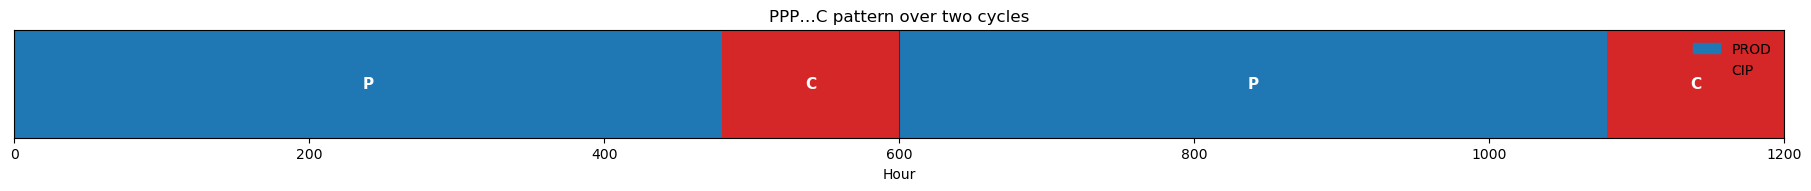

In [36]:
assert '_block_size' in globals() and 'T' in globals() and 'is_cip' in globals()

N = int(min(2*_block_size, T))
hours = np.arange(N)
phase = np.array(["CIP" if is_cip(i) else "PROD" for i in hours])

# contiguous segments
runs = []
for val, grp in it.groupby(enumerate(phase), key=lambda x: x[1]):
    grp = list(grp)
    start = grp[0][0]
    end   = grp[-1][0] + 1         
    runs.append((val, start, end))

COL = {"PROD": "#1f77b4", "CIP": "#d62728"}

fig_pc, ax = plt.subplots(figsize=(18, 1.8), constrained_layout=True)

for val, s, e in runs:
    ax.broken_barh([(s, e - s)], (0, 1), facecolors=COL[val], edgecolors="none")
    ax.text((s + e) / 2, 0.5, "P" if val == "PROD" else "C",
            ha="center", va="center", fontsize=11, color="white", fontweight="bold")

# Cycle separators
for k in range(0, N + 1, _block_size):
    ax.axvline(k, color="black", linewidth=0.8, alpha=0.5)

ax.set_xlim(0, N); ax.set_ylim(0, 1)
ax.set_yticks([]); ax.set_xlabel("Hour")
ax.set_title("PPP…C pattern over two cycles")
# Legend
ax.legend([Patch(color=COL["PROD"]), Patch(color=COL["CIP"])], ["PROD", "CIP"],
          loc="upper right", frameon=False)
plt.show()

Visualization of the alternating production (PROD) and clean-in-place (CIP) phases within two consecutive operating cycles of the KTB1 continuous biomanufacturing process. Each horizontal bar represents one hour of operation, color-coded as blue for production and red for cleaning. Vertical dashed lines indicate the start of each new cycle of duration = P + C hours, where P is the maximum production period and C the scheduled CIP downtime. The timeline clearly illustrates the repetitive scheduling pattern used in the DTU-dLCA framework to synchronize the dynamic life-cycle inventory with the process operating states

 ## PLOT 3. Foreground electricity demand of total process and individual equipment with CIP 

In [48]:
# Preconditions
assert '_fg_sorted' in globals() and '_time_utc' in globals() and 'is_cip' in globals(), \
       "Run §7.2 first (define _fg_sorted, _time_utc, is_cip)."

# Output folder
OUT = Path(r"C:\Users\XXX")
OUT.mkdir(parents=True, exist_ok=True)

# quality
FIGSIZE        = (24, 8)
DISPLAY_DPI    = 1200
EXPORT_PNG_DPI = 1200

# Colors
LINE_COLOR = {
    "Total":        "#800080",  # purple
    "CSTR":         "#1f77b4",  # blue
    "Hydrocyclone": "#ff7f0e",  # orange
    "Centrifuge":   "#2ca02c",  # green
    "Pump":         "#d62728",  # red
}

#  DATE WINDOW 
START_DATE = "2024-12-01"
END_DATE   = "2025-01-01"   

# W → kW
x_hours = _fg_sorted["Time"].astype(float).to_numpy()
raw = {
    "CSTR":         (_fg_sorted["Reactor_Energy"]    .astype(float)/1000.0).to_numpy(),
    "Hydrocyclone": (_fg_sorted["HC_Energy"]         .astype(float)/1000.0).to_numpy(),
    "Centrifuge":   (_fg_sorted["Centrifuge_Energy"] .astype(float)/1000.0).to_numpy(),
    "Pump":         (_fg_sorted["VSP_Energy"]        .astype(float)/1000.0).to_numpy(),
}
raw_total = raw["CSTR"] + raw["Hydrocyclone"] + raw["Centrifuge"] + raw["Pump"]


prod_mask_full = np.fromiter((not is_cip(i) for i in range(len(x_hours))), dtype=bool, count=len(x_hours))

# Date filter 
_idx = pd.to_datetime(_time_utc, utc=True)  # ensure UTC-aware timestamps
if START_DATE or END_DATE:
    start = pd.to_datetime(START_DATE, utc=True) if START_DATE else _idx.min()
    end   = pd.to_datetime(END_DATE,   utc=True) if END_DATE   else _idx.max()
    sel = (_idx >= start) & (_idx < end)  # end exclusive
else:
    sel = np.ones(len(_idx), dtype=bool)

if not np.any(sel):
    raise ValueError("No data in the selected date window.")

x_hours   = x_hours[sel]
for k in raw:
    raw[k] = raw[k][sel]
raw_total = raw_total[sel]
prod_mask = prod_mask_full[sel]

# profiles 
flat = {}
for name, y in raw.items():
    const_val = float(np.nanmedian(y[prod_mask])) if prod_mask.any() else float(np.nanmedian(y))
    flat[name] = np.where(prod_mask, const_val, 0.0)
flat_total = flat["CSTR"] + flat["Hydrocyclone"] + flat["Centrifuge"] + flat["Pump"]

USE_FLAT_DEFAULT = True

def _common_ylim(series_dict, total_series):
    ymax = max(np.nanmax(total_series), *[np.nanmax(v) for v in series_dict.values()]) * 1.05
    return (0.0, float(ymax if np.isfinite(ymax) and ymax > 0 else 1.0))

def _save(fig, stem):
    """Save both PDF and 1200 dpi PNG in OUT folder."""
    fig.savefig(OUT / f"{stem}.pdf", bbox_inches="tight")
    fig.savefig(OUT / f"{stem}.png", dpi=EXPORT_PNG_DPI, bbox_inches="tight", facecolor="white")

def plot_single(name: str, *, flat_profiles: bool = USE_FLAT_DEFAULT, ylim=None, show_cip=False, fname: str = None):
    if name == "Total":
        y = flat_total if flat_profiles else raw_total
    else:
        y = (flat if flat_profiles else raw)[name]

    if ylim is None:
        series_dict = flat if flat_profiles else raw
        total_series = flat_total if flat_profiles else raw_total
        ylim = _common_ylim(series_dict, total_series)

    fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DISPLAY_DPI)
    ax.plot(x_hours, y, color=LINE_COLOR.get(name, "#444"), lw=2.0, label=name)
    ax.set_xlim(x_hours.min(), x_hours.max())
    ax.set_ylim(*ylim)
    ax.set_xlabel("Hours")
    ax.set_ylabel("Power (kW)")
    ax.xaxis.set_major_locator(MultipleLocator(168))  # weekly
    ax.xaxis.set_minor_locator(MultipleLocator(24))   # daily
    ax.grid(True, linestyle=":", linewidth=0.6, alpha=0.6)
    if show_cip:
        i = 0
        while i < len(x_hours):
            if not prod_mask[i]:
                j = i
                while j < len(x_hours) and not prod_mask[j]:
                    j += 1
                ax.axvspan(x_hours[i], x_hours[j-1] if j > i else x_hours[i],
                           color="0.9", alpha=0.5, zorder=0)
                i = j
            else:
                i += 1
    ax.legend(loc="upper left", frameon=True)
    #ax.set_title(f"Energy • {name} (kW) — {'flat PROD' if flat_profiles else 'raw'}", pad=10)
    plt.tight_layout()
    base = fname or f"energy_{name.lower()}_{'flat' if flat_profiles else 'raw'}"
    _save(fig, base)
    plt.show()
    plt.close(fig)

# Multi-axis plot
def _fmt_no_leading_zero(decimals):
    def _f(x, pos):
        s = f"{x:.{decimals}f}"
        if s.startswith("-0"): return "-" + s[2:]
        return s[1:] if s.startswith("0") else s
    return FuncFormatter(_f)

def plot_all_multiaxis_with_cip(*, flat_profiles: bool = USE_FLAT_DEFAULT, fname: str = None):
    S   = flat if flat_profiles else raw
    TOT = flat_total if flat_profiles else raw_total

    YLIMS = {
        "Total":        (0.000, 0.090),
        "CSTR":         (0.000, 0.025),
        "Hydrocyclone": (0.000, 0.0050),
        "Centrifuge":   (0.000, 0.020),
        "Pump":         (0.000, 0.010),
    }
    DEC = {"Hydrocyclone": 4, "Pump": 3, "CSTR": 3, "Centrifuge": 3}

    fig, ax0 = plt.subplots(figsize=FIGSIZE, dpi=DISPLAY_DPI)
    fig.subplots_adjust(right=0.68)
    lines = []

    ln_tot, = ax0.plot(x_hours, TOT, color=LINE_COLOR["Total"], lw=1.8, label="Total")
    ax0.set_xlim(x_hours.min(), x_hours.max())
    ax0.set_ylim(*YLIMS["Total"])
    ax0.set_xlabel("Hours")
    ax0.set_ylabel("Total (kW)", color=LINE_COLOR["Total"])
    ax0.tick_params(axis="y", colors=LINE_COLOR["Total"], labelsize=10, pad=4)
    ax0.grid(True, linestyle=":", linewidth=0.6, alpha=0.6)

    i = 0
    while i < len(x_hours):
        if not prod_mask[i]:
            j = i
            while j < len(x_hours) and not prod_mask[j]:
                j += 1
            ax0.axvspan(x_hours[i], x_hours[j-1] if j > i else x_hours[i],
                        color="0.9", alpha=0.35, zorder=0)
            i = j
        else:
            i += 1
    lines.append(ln_tot)

    order = ["CSTR", "Hydrocyclone", "Centrifuge", "Pump"]
    offset = 12
    for name in order:
        y = S[name]
        ax = ax0.twinx()
        ax.spines["right"].set_position(("outward", offset))
        ax.spines["right"].set_linewidth(0.8)
        ln, = ax.plot(x_hours, y, color=LINE_COLOR[name], lw=1.4, alpha=0.95, label=name)
        ax.set_ylim(*YLIMS[name])
        ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
        ax.yaxis.set_major_formatter(_fmt_no_leading_zero(DEC.get(name, 3)))
        ax.set_ylabel(f"{name} (kW)", color=LINE_COLOR[name], labelpad=6)
        ax.tick_params(axis="y", colors=LINE_COLOR[name], labelsize=10, pad=6)
        offset += 36
        lines.append(ln)

    #ax0.set_title(f"Energy • Total, CSTR, Hydrocyclone, Centrifuge, Pump (kW) — "
                  #f"{'flat PROD' if flat_profiles else 'raw'}", pad=10)
    ax0.legend(lines, [ln.get_label() for ln in lines], loc="upper left", ncol=2, frameon=True)

    plt.tight_layout()
    base = fname or f"energy_all_multiaxis_with_CIP_{'flat' if flat_profiles else 'raw'}"
    _save(fig, base)
    plt.show()
    plt.close(fig)

#plot
plot_single("Total", flat_profiles=True, show_cip=True, fname="FG_DEC_Total")
plot_all_multiaxis_with_cip(flat_profiles=True, fname="FG_DEC_All")

 ## 7.3 Dynamic hourly LCIA over tiled blocks (PROD + CIP) - Base


In [40]:
# Preconditions 
reqs = ['build_fu_for_interval', 'T', 'FG_ACT', 'BG_ACT',
        'LCIA_METHODS_RESOLVED', 'BG_INTENSITY_HOURLY', '_time_utc']
missing = [r for r in reqs if r not in globals()]
assert not missing, f"Run previous sections first; missing: {missing}"

# horizon
first_mk = next(iter(LCIA_METHODS_RESOLVED.keys()))
T_eff = int(min(
    T,                                       
    len(pd.DatetimeIndex(_time_utc)),        
    len(BG_INTENSITY_HOURLY[first_mk])       
))
print(f"✓ 7.3: Effective scoring horizon T_eff = {T_eff}")

# Foreground 
unit_scores_fg = {mk: {} for mk in LCIA_METHODS_RESOLVED.keys()}
all_fg_acts = [k for k in FG_ACT.values() if k]

t_cache0 = time.time()
for mk, mt in LCIA_METHODS_RESOLVED.items():
    for act_key in all_fg_acts:
        try:
            lca = bc.LCA({act_key: 1.0}, method=mt); lca.lci(); lca.lcia()
            unit_scores_fg[mk][act_key] = float(lca.score)
        except Exception as e:
            print(f"⚠ unit-score FG cache: {mk}: could not score {act_key}: {e}")
            unit_scores_fg[mk][act_key] = 0.0
t_cache1 = time.time()
print(f"✓ 7.3a: FG unit-score cache ready "
      f"({len(all_fg_acts)} activities, {len(LCIA_METHODS_RESOLVED)} methods) "
      f"in {t_cache1 - t_cache0:.2f}s")

# Hour-by-hour scoring 
rows = []
t0 = time.time()

fg_keys = set(FG_ACT.values())  

for i in range(T_eff):
    # Build FU + log for this hour 
    fu, log = build_fu_for_interval(i)

    ts = pd.DatetimeIndex(_time_utc)[i]

    for mk in LCIA_METHODS_RESOLVED.keys():
        score_fg = 0.0
        score_bg = 0.0

        # sumover FG activities only
        if fu:
            us_fg = unit_scores_fg[mk]
            for act_key, amt in fu.items():
                if act_key in fg_keys:         
                    score_fg += amt * us_fg.get(act_key, 0.0)

        # Background electricity
        kwh = float(log.get('kWh_total', 0.0))
        if kwh > 0.0:
            try:
                bg_int = float(BG_INTENSITY_HOURLY[mk].loc[ts, 'Total'])  
            except KeyError:
                bg_row = BG_INTENSITY_HOURLY[mk].reindex([ts])
                bg_int = float(bg_row['Total'].ffill().bfill().iloc[0])
            score_bg = bg_int * kwh

        # CIP wastewater 
        cip_m3ph = float(log.get('CIP_m3ph', 0.0))
        if cip_m3ph > 0.0 and FG_ACT.get(CIP_LABEL):
            us_cip = unit_scores_fg[mk].get(FG_ACT[CIP_LABEL], 0.0)
            score_fg += cip_m3ph * us_cip

        # store detailed + total
        log[f"LCIA_{mk}_FG"] = score_fg
        log[f"LCIA_{mk}_BG"] = score_bg
        log[f"LCIA_{mk}"]    = score_fg + score_bg

    rows.append(log)

t1 = time.time()
print(f"⏱ 7.3: Scored {len(rows)} intervals (T_eff={T_eff}) in {t1 - t0:.2f}s "
      f"(FG cache built in {t_cache1 - t_cache0:.2f}s)")

# DataFrame and preview 
lcia_hourly = pd.DataFrame(rows).set_index("Time").sort_index()
keep_cols = ["block", "phase", "kWh_total", "CIP_m3ph"] + \
            [f"LCIA_{mk}" for mk in LCIA_METHODS_RESOLVED.keys()]

print("✓ 7.3: Hourly LCIA preview (first 10 rows):")
display(lcia_hourly[keep_cols].head(10))

mk0 = first_mk
if f"LCIA_{mk0}" in lcia_hourly.columns:
    std_total = float(lcia_hourly[f"LCIA_{mk0}"].std())
    std_bg    = float(lcia_hourly.get(f"LCIA_{mk0}_BG", pd.Series(0.0, lcia_hourly.index)).std())
    std_fg    = float(lcia_hourly.get(f"LCIA_{mk0}_FG", pd.Series(0.0, lcia_hourly.index)).std())
    print(f"σ(LCIA total)={std_total:.3e} | σ(BG)={std_bg:.3e} | σ(FG)={std_fg:.3e}")

# Inspection
try:
    _dbg = pd.DataFrame({
        "i": list(range(min(6, T_eff))),
        "ts": [pd.DatetimeIndex(_time_utc)[j] for j in range(min(6, T_eff))],
        "kWh_total": [float(build_fu_for_interval(j)[1]['kWh_total']) for j in range(min(6, T_eff))],
    })
    _dbg["bg_intensity"] = [
        float(BG_INTENSITY_HOURLY[first_mk].loc[_dbg.loc[j, "ts"], "Total"])
        for j in _dbg.index
    ]
    display(_dbg)
except Exception as _e:
    print("DBG table skipped:", _e)

✓ 7.3: Effective scoring horizon T_eff = 5399
✓ 7.3a: FG unit-score cache ready (9 activities, 1 methods) in 36.46s
⏱ 7.3: Scored 5399 intervals (T_eff=5399) in 3.25s (FG cache built in 36.46s)
✓ 7.3: Hourly LCIA preview (first 10 rows):


block phase  kWh_total  CIP_m3ph  LCIA_ecosystem quality
Time                                                          
0         1  PROD   0.040700       0.0                0.000034
1         1  PROD   0.041275       0.0                0.000035
2         1  PROD   0.041532       0.0                0.000035
3         1  PROD   0.041566       0.0                0.000035
4         1  PROD   0.041598       0.0                0.000035
5         1  PROD   0.041624       0.0                0.000035
6         1  PROD   0.041629       0.0                0.000035
7         1  PROD   0.041637       0.0                0.000035
8         1  PROD   0.041645       0.0                0.000035
9         1  PROD   0.041653       0.0                0.000035

σ(LCIA total)=1.362e-05 | σ(BG)=6.577e-11 | σ(FG)=1.362e-05


i                        ts  kWh_total  bg_intensity
0  0 2024-08-10 22:00:00+00:00   0.040700  1.846389e-09
1  1 2024-08-10 23:00:00+00:00   0.041275  1.852399e-09
2  2 2024-08-11 00:00:00+00:00   0.041532  1.872581e-09
3  3 2024-08-11 01:00:00+00:00   0.041566  1.898377e-09
4  4 2024-08-11 02:00:00+00:00   0.041598  1.952588e-09
5  5 2024-08-11 03:00:00+00:00   0.041624  1.864411e-09

## PLOT 4. Hourly life-cycle impact intensity of electricity generation by technology + Total (ENTSO-E, full year)

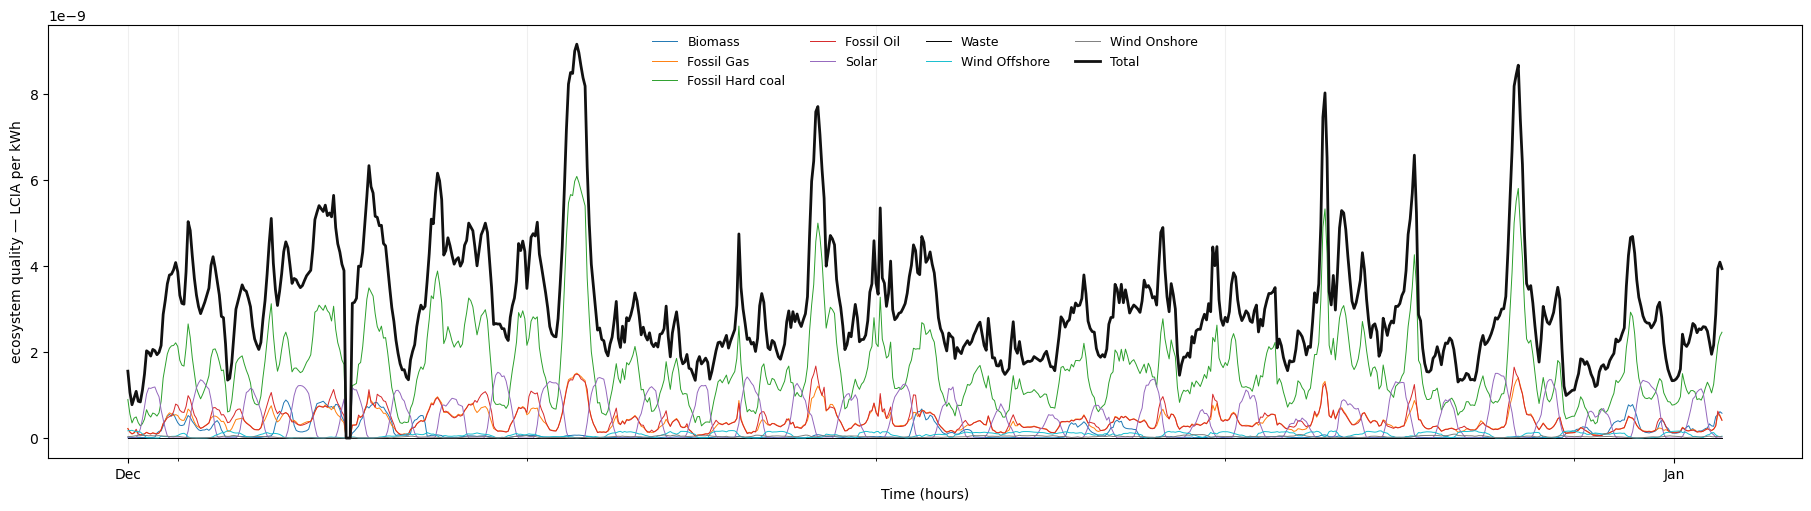

In [41]:
mk  = next(iter(LCIA_METHODS_RESOLVED.keys()))
dfI = BG_INTENSITY_HOURLY[mk]  

COLORS = {
    "Biomass_pct": "#1f77b4", "Fossil Gas_pct": "#ff7f0e", "Fossil Hard coal_pct": "#2ca02c",
    "Fossil Oil_pct": "#d62728", "Solar_pct": "#9467bd", "Waste_pct": "#000000",
    "Wind Offshore_pct": "#17becf", "Wind Onshore_pct": "#7f7f7f", "Total": "#111111",
}

# FLEXIBLE DATE
start_date = "2024-12-01"  # e.g. "2025-01-01"
end_date   = "2025-01-01"  # e.g. "2025-06-30"
# If both None → plot full year

if start_date and end_date:
    dfI = dfI.loc[start_date:end_date]

fig, ax = plt.subplots(figsize=(18,5), constrained_layout=True)
for col in [c for c in dfI.columns if c != "Total"]:
    label = col.replace("_pct","")
    ax.plot(dfI.index, dfI[col], lw=0.7, color=COLORS.get(col, None), label=label)
ax.plot(dfI.index, dfI["Total"], lw=2.0, color=COLORS["Total"], label="Total")

ax.set_ylabel(f"{mk} — LCIA per kWh")
ax.set_xlabel("Time (hours)")
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
ax.xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=1))
ax.grid(True, which='both', axis='x', alpha=0.2)
ax.legend(ncol=4, fontsize=9, frameon=False)
#ax.set_title(f"ENTSO-E background — Hourly per‑kWh LCIA by technology ({mk})")

# SAVE
#save_path = r"C:\Users\XXX.png"
#fig.savefig(save_path, dpi=600, bbox_inches="tight")

# SHOW
plt.show()

## PLOT 5. Hourly background electricity impact by technology and total (LCIA × kWh)

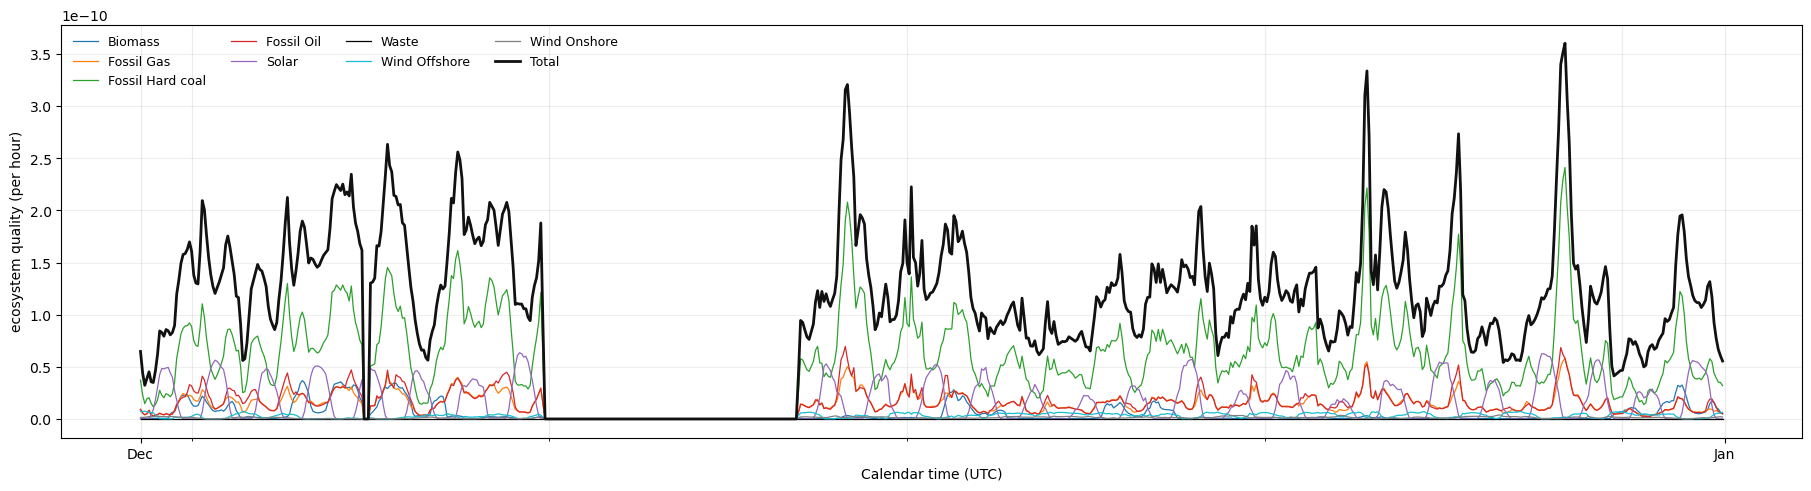

In [49]:
# Preconditions (from earlier sections)
assert 'mk' in globals() and 'BG_INTENSITY_HOURLY' in globals(), "Resolve mk and BG_INTENSITY_HOURLY in §7.1."
assert 'E_tot_kWh' in globals() and 'T' in globals() and len(E_tot_kWh) >= int(T), "Build E_tot_kWh, T in §7.2f."
assert isinstance(_time_utc, pd.DatetimeIndex), "_time_utc must be a DatetimeIndex (UTC)."
assert 'is_cip' in globals(), "is_cip(i) needed if you use flat PROD."

START_DATE = "2024-12-01"          # e.g. "2024-12-01"  
END_DATE   = "2025-01-01"        # e.g. "2025-01-01" 

# Colors
COLOR_MAP = {
    "Biomass": "#1f77b4", "Biomass_pct": "#1f77b4",
    "Fossil Gas": "#ff7f0e", "Fossil Gas_pct": "#ff7f0e",
    "Fossil Hard coal": "#2ca02c", "Fossil Hard coal_pct": "#2ca02c",
    "Fossil Oil": "#d62728", "Fossil Oil_pct": "#d62728",
    "Solar": "#9467bd", "Solar_pct": "#9467bd",
    "Waste": "#000000", "Waste_pct": "#000000",
    "Wind Offshore": "#17becf", "Wind Offshore_pct": "#17becf",
    "Wind Onshore": "#7f7f7f", "Wind Onshore_pct": "#7f7f7f",
    "Total": "#111111",
}

# Horizon
ts_full = _time_utc[:int(T)]                      

if START_DATE or END_DATE:
    start = pd.to_datetime(START_DATE, utc=True) if START_DATE else ts_full.min()
    end   = pd.to_datetime(END_DATE,   utc=True) if END_DATE   else ts_full.max()
    sel = (ts_full >= start) & (ts_full < end)   
else:
    y0 = ts_full[0].year
    sel = (ts_full.year == y0)

if not np.any(sel):
    raise ValueError("No data in the selected date window.")

ts = ts_full[sel]

# Background intensity 
bg_df = BG_INTENSITY_HOURLY[mk].reindex(ts).ffill().bfill()
tech_cols = [c for c in bg_df.columns if c != "Total"]

# Foreground 
fg_kWh_full = np.asarray(E_tot_kWh[:int(T)], dtype=float)

# Optional flat-PROD electricity (median during PROD; CIP=0)
USE_FLAT = False  # set True if you want constant PROD kWh/h
if USE_FLAT:
    total_kW_full = (
        _fg_sorted["Reactor_Energy"].to_numpy(dtype=float) +
        _fg_sorted["HC_Energy"].to_numpy(dtype=float) +
        _fg_sorted["Centrifuge_Energy"].to_numpy(dtype=float) +
        _fg_sorted["VSP_Energy"].to_numpy(dtype=float)
    )[:int(T)] / 1000.0
    prod_mask_full = np.fromiter((not is_cip(i) for i in range(len(total_kW_full))),
                                 dtype=bool, count=len(total_kW_full))
    const_kw  = float(np.nanmedian(total_kW_full[prod_mask_full])) if prod_mask_full.any() else float(np.nanmedian(total_kW_full))
    fg_kWh_full = np.where(prod_mask_full, const_kw, 0.0)

fg_kWh = fg_kWh_full[sel]                            

# Per-technology hourly BG impact 
impact_by_tech = bg_df[tech_cols].multiply(fg_kWh, axis=0)
impact_total   = bg_df["Total"].to_numpy(dtype=float) * fg_kWh

# Plot
fig, ax = plt.subplots(figsize=(18, 4.8), constrained_layout=True)

# Tech lines
for col in tech_cols:
    label = col[:-4] if col.endswith("_pct") else col
    ax.plot(ts,
            impact_by_tech[col].to_numpy(dtype=float),
            lw=0.9,
            color=COLOR_MAP.get(col, COLOR_MAP.get(label, "#555555")),
            label=label)

# Total 
ax.plot(ts, impact_total, lw=2.0, color=COLOR_MAP["Total"], label="Total")

# Axes, ticks, grid
ax.set_ylabel(f"{mk} (per hour)")
ax.set_xlabel("Calendar time (UTC)")
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
ax.xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=1))
ax.grid(True, which='both', axis='x', alpha=0.25)
ax.grid(True, which='major', axis='y', alpha=0.2)
ax.legend(ncol=4, frameon=False, fontsize=9)

# SAVE
OUT = Path(r"C:\Users\XXX")
OUT.mkdir(parents=True, exist_ok=True)
base = f"BG_impact_by_technology_hourly_{mk.replace(' ','_')}_{'flat' if USE_FLAT else 'raw'}"
fig.savefig(OUT / f"{base}.pdf", bbox_inches="tight")
fig.savefig(OUT / f"{base}.png", dpi=1200, bbox_inches="tight", facecolor="white")
plt.show()

## PLOT 6. Cumulative system LCIA over time

In [50]:
df = LCIA_SYSTEM_HOURLY.sort_index().copy()
cols = ["LCIA_FG", "LCIA_BG", "LCIA_Total"]
df[cols] = df[cols].fillna(0.0)

# cumulative per hour
ACC = df[cols].cumsum()

final_fg, final_bg, final_tot = ACC.iloc[-1].tolist()
print(f"Cumulative {mk}: FG={final_fg:.6g}, BG={final_bg:.6g}, Total={final_tot:.6g}")

# plot 
fig, ax = plt.subplots(figsize=(16,4), constrained_layout=True)
ax.plot(ACC.index, ACC["LCIA_FG"], lw=1.0, label="FG cum")
ax.plot(ACC.index, ACC["LCIA_BG"], lw=1.0, label="BG cum")
ax.plot(ACC.index, ACC["LCIA_Total"], lw=2.0, label="Total cum")


ax.set_ylabel(f"{mk} (cumulative)")
ax.set_xlabel("Time")
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
ax.grid(True, which='both', axis='x', alpha=0.2)
ax.legend(ncol=3, frameon=False, fontsize=9)
plt.show()

NameError: name 'LCIA_SYSTEM_HOURLY' is not defined

In [92]:
mk0 = next(iter(LCIA_METHODS_RESOLVED.keys()))
print("σ BG intensity per kWh:", float(BG_INTENSITY_HOURLY[mk0]['Total'].reindex(pd.DatetimeIndex(_time_utc)[:T]).std()))
print("σ plant kWh per hour  :", float(np.std(E_tot_kWh[:T])))
print("σ FG total per hour   :", float(LCIA_FG_BY_LABEL['Total_FG'].std()))
print("σ System total per hr :", float(LCIA_SYSTEM_HOURLY['LCIA_Total'].std()))


σ BG intensity per kWh: 1.2593101140642615e-09
σ plant kWh per hour  : 0.016243261689694307
σ FG total per hour   : 1.3891457026377017e-05
σ System total per hr : 1.389150049275831e-05


 ## 8. Optimization

In [61]:
# Preconditions 
req = ['BG_INTENSITY_HOURLY','LCIA_METHODS_RESOLVED','percentage_final',
       'MAX_BLOCK_HOURS','CIP_HOURS','YEAR_HOURS',
       '_fg_block','EQUIP','price_utc','FG_ACT','SCALE']
_missing = [x for x in req if x not in globals()]
assert not _missing, f"Missing upstream variables: {_missing}"
assert MAX_BLOCK_HOURS > 0 and CIP_HOURS >= 0 and YEAR_HOURS > 0


SC = {
    "base":  "#7f7f7f",   
    "env":   "#2ca02c",   
    "price": "#ff7f0e",   
}

#  parameters
P = int(MAX_BLOCK_HOURS)           # PROD hours per cycle
C = int(CIP_HOURS)                 # CIP hours per cycle
L = P + C                          # window length
K = int(YEAR_HOURS) // L           # full cycles
R = int(YEAR_HOURS) %  L           # remainder hours
P_rem = min(R, P)                  # remainder PROD hours 
C_rem = R - P_rem                  # remainder CIP hours 

# Annual UTC index from ENTSO‑E 
YEAR_IDX = next(iter(BG_INTENSITY_HOURLY.values())).index
N = len(YEAR_IDX)
pos_map = pd.Series(np.arange(N), index=pd.DatetimeIndex(YEAR_IDX))  # ts → pos

#  BG intensity, aggregated 
methods = list(LCIA_METHODS_RESOLVED.keys())
WEIGHT_MK = {mk: 1.0 for mk in methods}          
w_sum = sum(max(0.0, float(WEIGHT_MK.get(mk, 0.0))) for mk in methods) or 1.0
w_norm = {mk: float(WEIGHT_MK.get(mk, 0.0)) / w_sum for mk in methods}

I_env_year = np.zeros(N, dtype=float)
for mk in methods:
    I_env_year += w_norm[mk] * BG_INTENSITY_HOURLY[mk].reindex(YEAR_IDX)['Total'].to_numpy()

# Price per kWh 
price_per_kWh_year = pd.to_numeric(price_utc, errors='coerce') \
                        .reindex(YEAR_IDX).ffill().bfill().to_numpy() / 1000.0  # EUR/MWh → EUR/kWh

# rom DI block (shape P)
B = len(_fg_block)
assert B >= 2, "DI block (_fg_block) must have ≥2 rows"
_blk = _fg_block.iloc[:(P + 1)].copy() if B > (P + 1) else _fg_block
Pm = _blk[EQUIP].astype(float).to_numpy()                  # [P+1, n_equip] in W
block_E_each = 0.5 * (Pm[1:, :] + Pm[:-1, :]) / 1000.0     # [P, n_equip] kWh per interval
block_kWh    = block_E_each.sum(axis=1).astype(float)      # [P]

#  Optimizer 
def run_dp_optimize(cost_per_kWh_year: np.ndarray, label: str) -> tuple[pd.DataFrame, float, float]:
    t0 = time.time()
    windows_P = sliding_window_view(cost_per_kWh_year, window_shape=P)  # [N-P+1, P]
    conv_full = windows_P @ block_kWh                                   # [N-P+1]
    M_full = N - L + 1
    if M_full <= 0:
        raise RuntimeError("Year index shorter than one (P+C) window.")
    cost_full = conv_full[:M_full]

    K_full = int(K)
    dp   = np.full((K_full + 1, M_full), np.inf, dtype=float)
    prev = np.full((K_full + 1, M_full), -1, dtype=int)
    take = np.zeros((K_full + 1, M_full), dtype=bool)
    dp[0, :] = 0.0

    for i in range(M_full):
        if i > 0:
            better = dp[:, i-1] < dp[:, i]
            dp[:, i]   = np.where(better, dp[:, i-1], dp[:, i])
            prev[:, i] = np.where(better, prev[:, i-1], prev[:, i])
        j = i - L
        for kk in range(1, K_full + 1):
            base = 0.0 if (kk-1) == 0 and j < 0 else (dp[kk-1, j] if j >= 0 else np.inf)
            cand = cost_full[i] + base
            if cand < dp[kk, i]:
                dp[kk, i] = cand
                prev[kk, i] = j
                take[kk, i] = True
  
    starts_full = []
    i, kk = M_full - 1, K_full
    while kk > 0 and i >= 0:
        if take[kk, i]:
            starts_full.append(i)
            i = prev[kk, i]
            kk -= 1
        else:
            i -= 1
    starts_full = starts_full[::-1]

    opt_cost_rem, start_rem = 0.0, None
    if R > 0 and P_rem > 0:
        windows_Pr = sliding_window_view(cost_per_kWh_year, window_shape=P_rem)  # [N-P_rem+1, P_rem]
        conv_rem   = windows_Pr @ block_kWh[:P_rem]
        busy = np.zeros(N, dtype=np.int8)
        for s in starts_full:
            busy[s:(s+L)] = 1
        M_rem = max(0, N - (P_rem + C_rem) + 1)
        csum  = np.concatenate([[0], np.cumsum(busy)])
        valid = [s for s in range(M_rem) if (csum[s + (P_rem + C_rem)] - csum[s]) == 0]
        if valid:
            valid = np.array(valid, dtype=int)
            best_idx = int(valid[np.argmin(conv_rem[valid])])
            start_rem   = best_idx
            opt_cost_rem = float(conv_rem[best_idx])

    # schedule dataframe
    rows = []
    for n, s in enumerate(starts_full, start=1):
        rows.append({
            "cycle": n, "type": "full",
            f"{label}_cost": float(cost_full[s]),
            "prod_start": YEAR_IDX[s],
            "prod_end":   YEAR_IDX[min(s + P, N-1)],
            "cip_start":  YEAR_IDX[min(s + P, N-1)],
            "cip_end":    YEAR_IDX[min(s + L, N-1)],
            "prod_hours": P, "cip_hours": C
        })
    if start_rem is not None:
        s = start_rem
        rows.append({
            "cycle": len(starts_full) + 1, "type": "remainder",
            f"{label}_cost": float(opt_cost_rem),
            "prod_start": YEAR_IDX[s],
            "prod_end":   YEAR_IDX[min(s + P_rem, N-1)],
            "cip_start":  YEAR_IDX[min(s + P_rem, N-1)],
            "cip_end":    YEAR_IDX[min(s + P_rem + C_rem, N-1)],
            "prod_hours": P_rem, "cip_hours": C_rem
        })
    sched = pd.DataFrame(rows)
    total_cost = float(sum(r[f"{label}_cost"] for _, r in sched.iterrows()))
    return sched, total_cost, (time.time() - t0)

#  independent optimizations 
baseline_off = int(globals().get('CIP_START_OFFSET_H', 0)) % L
schedule_env_df,   total_bg_opt, t_env = run_dp_optimize(I_env_year,         label="env")
schedule_cost_df,  total_eur_opt, t_pr = run_dp_optimize(price_per_kWh_year, label="eur")
print(f"✓ 8.0: ENV optimization in {t_env:.3f}s | aggregated BG LCIA = {total_bg_opt:.6g}")
print(f"✓ 8.0: PRICE optimization in {t_pr:.3f}s | total EUR cost    = {total_eur_opt:.6g}")
display(schedule_env_df.head(6)); display(schedule_cost_df.head(6))

# Baseline 
def kwh_year_from_baseline() -> np.ndarray:
    v = np.zeros(N, float)
    K_full  = int(YEAR_HOURS) // L
    Rrem    = int(YEAR_HOURS) %  L
    Prem    = min(Rrem, P)
    for n in range(K_full):
        s = baseline_off + n*L
        if s >= N: break
        e = min(s + P, N); span = e - s
        if span > 0: v[s:e] += block_kWh[:span]
    if Prem > 0:
        s = baseline_off + K_full*L
        if s < N:
            e = min(s + Prem, N); span = e - s
            if span > 0: v[s:e] += block_kWh[:span]
    return v

#  optimized schedule
def kwh_year_from_schedule(schedule_df: pd.DataFrame) -> np.ndarray:
    v = np.zeros(N, float)
    if schedule_df is None or schedule_df.empty:
        return v
    for r in schedule_df.itertuples(index=False):
        s = pos_map.get(pd.to_datetime(r.prod_start))
        if pd.isna(s): continue
        s = int(s)
        span = int(getattr(r, 'prod_hours', P))
        e = min(s + span, N)
        if e > s:
            v[s:e] += block_kWh[:(e - s)]
    return v

# FG unit scores 
def _lcia_per_unit_agg(act_key) -> float:
    score = 0.0
    for mk, mt in LCIA_METHODS_RESOLVED.items():
        lca = bc.LCA({act_key: 1.0}, method=mt); lca.lci(); lca.lcia()
        score += w_norm[mk] * float(lca.score)
    return float(score)

FG_UNIT_SCORES = {lbl: _lcia_per_unit_agg(key) for lbl, key in FG_ACT.items() if key is not None}

# FG per‑hour
FG_BLOCK_LCIA = np.zeros(P, float)
_cols_by_lbl = {lbl: [cand for cand in ([lbl] + [*(_ for _ in [])])] for lbl in FG_ACT}  
if '_FG_DI_SYNONYMS' in globals():
    _cols_by_lbl = _FG_DI_SYNONYMS
else:
    _cols_by_lbl = {lbl: [lbl] for lbl in FG_ACT}

for j in range(P):
    row = _fg_block.iloc[min(j, len(_fg_block)-1)]
    s = 0.0
    for lbl, key in FG_ACT.items():
        if (key is None) or (lbl == globals().get('CIP_LABEL', 'CIP_Wastewater')):
            continue
        val = 0.0
        for cand in _cols_by_lbl.get(lbl, [lbl]):
            if cand in row:
                v = float(row[cand])
                val = (SCALE.get(lbl, 1.0) * v) if np.isfinite(v) else 0.0
                break
        if val:
            s += val * FG_UNIT_SCORES[lbl]
    FG_BLOCK_LCIA[j] = s

# FG per‑hour LCIA 
FG_CIP_LCIA = np.zeros(C, float)
if C > 0 and globals().get('CIP_ENABLED', True):
    cip_lbl = globals().get('CIP_LABEL', 'CIP_Wastewater')
    if cip_lbl in FG_ACT and FG_ACT[cip_lbl] is not None:
        _cip_rate_m3ph = float(globals().get('_cip_rate_m3ph', 0.0))
        FG_CIP_LCIA[:] = (_cip_rate_m3ph * FG_UNIT_SCORES[cip_lbl])

# FG LCIA 
def fg_year_from_schedule(schedule_df: pd.DataFrame | None) -> np.ndarray:
    v = np.zeros(N, float)
    if schedule_df is None or schedule_df.empty:
        return v
    for r in schedule_df.itertuples(index=False):
        # PROD hours
        s = pos_map.get(pd.to_datetime(r.prod_start))
        if not pd.isna(s):
            s = int(s); span = int(getattr(r, 'prod_hours', P))
            e = min(s + span, N); Lspan = e - s
            if Lspan > 0:
                v[s:e] += FG_BLOCK_LCIA[:Lspan]
        # CIP hours
        ch = int(getattr(r, 'cip_hours', C))
        if ch > 0:
            sc = pos_map.get(pd.to_datetime(r.cip_start))
            if not pd.isna(sc):
                sc = int(sc); ec = min(sc + ch, N); Lc = ec - sc
                if Lc > 0 and len(FG_CIP_LCIA) > 0:
                    v[sc:ec] += FG_CIP_LCIA[:Lc]
    return v

def fg_year_from_baseline() -> np.ndarray:
    v = np.zeros(N, float)
    # Full cycles
    K_full  = int(YEAR_HOURS) // L
    for n in range(K_full):
        s = baseline_off + n*L
        if s >= N: break
        e = min(s + P, N); span = e - s
        if span > 0:
            v[s:e] += FG_BLOCK_LCIA[:span]
        if C > 0:
            sc = min(s + P, N); ec = min(sc + C, N); Lc = ec - sc
            if Lc > 0:
                v[sc:ec] += FG_CIP_LCIA[:Lc]
    # Remainder
    if P_rem > 0:
        s = baseline_off + K_full*L
        if s < N:
            e = min(s + P_rem, N); span = e - s
            if span > 0:
                v[s:e] += FG_BLOCK_LCIA[:span]
            if C_rem > 0 and C > 0:
                sc = min(s + P_rem, N); ec = min(sc + C_rem, N); Lc = ec - sc
                if Lc > 0:
                    v[sc:ec] += FG_CIP_LCIA[:Lc]
    return v

# Build hourly series 
kwh_base = kwh_year_from_baseline()
kwh_env  = kwh_year_from_schedule(schedule_env_df)
kwh_pr   = kwh_year_from_schedule(schedule_cost_df)

bg_base  = kwh_base * I_env_year
bg_env   = kwh_env  * I_env_year
bg_pr    = kwh_pr   * I_env_year

eur_base = kwh_base * price_per_kWh_year
eur_env  = kwh_env  * price_per_kWh_year
eur_pr   = kwh_pr   * price_per_kWh_year

fg_base  = fg_year_from_baseline()
fg_env   = fg_year_from_schedule(schedule_env_df)
fg_pr    = fg_year_from_schedule(schedule_cost_df)

#  totals
print(f"Annual totals — BG LCIA: base={bg_base.sum():.6g}, env={bg_env.sum():.6g}, price={bg_pr.sum():.6g}")
print(f"Annual totals — EUR cost: base={eur_base.sum():.6g}, env={eur_env.sum():.6g}, price={eur_pr.sum():.6g}")
print(f"Annual totals — FG LCIA : base={fg_base.sum():.6g}, env={fg_env.sum():.6g}, price={fg_pr.sum():.6g}")


✓ 8.0: ENV optimization in 0.159s | aggregated BG LCIA = 4.2398e-07
✓ 8.0: PRICE optimization in 0.149s | total EUR cost    = 11.8456


cycle  type      env_cost                prod_start  \
0      1  full  4.178931e-08 2024-09-02 06:00:00+00:00   
1      2  full  4.159374e-08 2024-09-27 06:00:00+00:00   
2      3  full  4.599760e-08 2024-12-26 23:00:00+00:00   
3      4  full  4.261816e-08 2025-01-20 23:00:00+00:00   
4      5  full  5.066206e-08 2025-02-20 10:00:00+00:00   
5      6  full  5.494566e-08 2025-03-17 10:00:00+00:00   

                   prod_end                 cip_start  \
0 2024-09-22 06:00:00+00:00 2024-09-22 06:00:00+00:00   
1 2024-10-17 06:00:00+00:00 2024-10-17 06:00:00+00:00   
2 2025-01-15 23:00:00+00:00 2025-01-15 23:00:00+00:00   
3 2025-02-09 23:00:00+00:00 2025-02-09 23:00:00+00:00   
4 2025-03-12 10:00:00+00:00 2025-03-12 10:00:00+00:00   
5 2025-04-06 10:00:00+00:00 2025-04-06 10:00:00+00:00   

                    cip_end  prod_hours  cip_hours  
0 2024-09-27 06:00:00+00:00         480        120  
1 2024-10-22 06:00:00+00:00         480        120  
2 2025-01-20 23:00:00+00:00         480        120  
3 2025-02-14 23:00:00+00:00         480        120  
4 2025-03-17 10:00:00+00:00         480        120  
5 2025-04-11 10:00:00+00:00         480        120

cycle  type  eur_cost                prod_start                  prod_end  \
0      1  full  1.386974 2024-08-22 02:00:00+00:00 2024-09-11 02:00:00+00:00   
1      2  full  1.083719 2024-09-24 06:00:00+00:00 2024-10-14 06:00:00+00:00   
2      3  full  1.644064 2024-11-13 14:00:00+00:00 2024-12-03 14:00:00+00:00   
3      4  full  1.106579 2024-12-14 08:00:00+00:00 2025-01-03 08:00:00+00:00   
4      5  full  1.420660 2025-03-27 12:00:00+00:00 2025-04-16 12:00:00+00:00   
5      6  full  1.375497 2025-04-26 05:00:00+00:00 2025-05-16 05:00:00+00:00   

                  cip_start                   cip_end  prod_hours  cip_hours  
0 2024-09-11 02:00:00+00:00 2024-09-16 02:00:00+00:00         480        120  
1 2024-10-14 06:00:00+00:00 2024-10-19 06:00:00+00:00         480        120  
2 2024-12-03 14:00:00+00:00 2024-12-08 14:00:00+00:00         480        120  
3 2025-01-03 08:00:00+00:00 2025-01-08 08:00:00+00:00         480        120  
4 2025-04-16 12:00:00+00:00 2025-04-21 12:00:00+00:00         480        120  
5 2025-05-16 05:00:00+00:00 2025-05-21 05:00:00+00:00         480        120

Annual totals — BG LCIA: base=4.97923e-07, env=4.2398e-07, price=5.12935e-07
Annual totals — EUR cost: base=15.8611, env=13.6281, price=11.8456
Annual totals — FG LCIA : base=0.147094, env=0.147094, price=0.147094


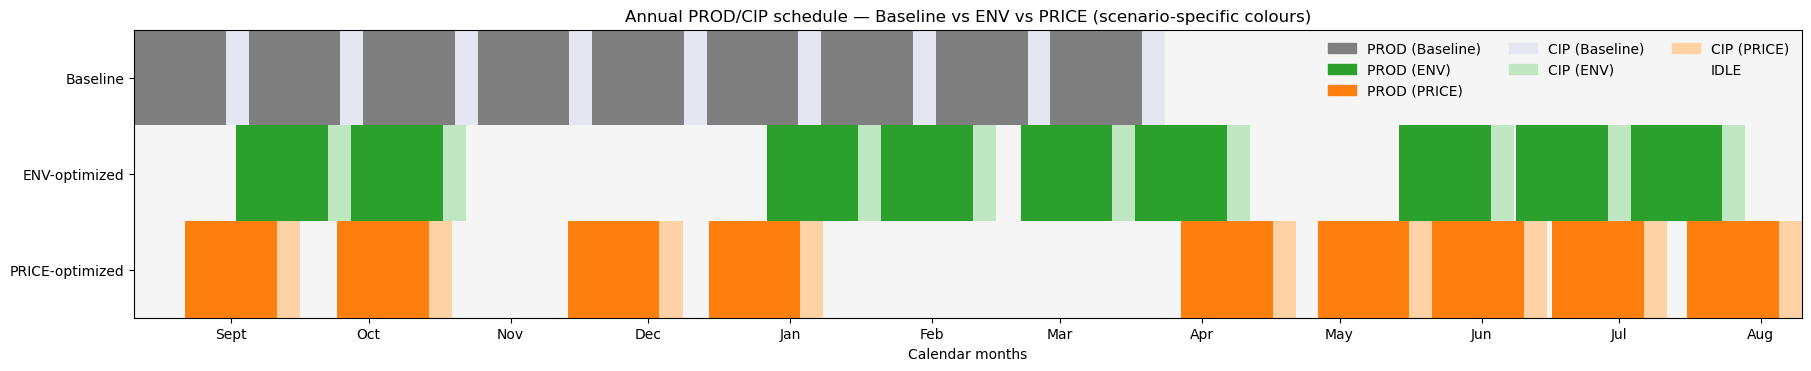

In [71]:
# Annual PROD/CIP heatmap 

assert 'YEAR_IDX' in globals() and 'schedule_env_df' in globals() and 'schedule_cost_df' in globals()
N, P, C, L = len(YEAR_IDX), int(MAX_BLOCK_HOURS), int(CIP_HOURS), int(MAX_BLOCK_HOURS + CIP_HOURS)
baseline_off = int(globals().get('CIP_START_OFFSET_H', 0)) % L
pos_map = pd.Series(np.arange(N), index=pd.DatetimeIndex(YEAR_IDX))

# Scenario
SC = {
    "base_prod":  "#7f7f7f",  # grey
    "base_cip":   "#e6e6f2",
    "idle":       "#f5f5f5",
    "env_prod":   "#2ca02c",  # green
    "env_cip":    "#bfe7c2",  # pale green
    "price_prod": "#ff7f0e",  # orange
    "price_cip":  "#ffd2a6",  # pale orange
}

def _hex_to_rgb01(h):
    h = h.lstrip("#")
    return tuple(int(h[i:i+2], 16)/255.0 for i in (0, 2, 4))

def _mark(state_arr, start_ts, end_ts, code):
    s = pos_map.get(pd.to_datetime(start_ts)); e = pos_map.get(pd.to_datetime(end_ts))
    if pd.isna(s) or pd.isna(e): return
    s = int(s); e = min(int(e) + 1, N)  
    state_arr[s:e] = code  

# Baseline 
state_base = np.zeros(N, dtype=np.uint8)
total_sched = int(YEAR_HOURS)
for k in range(total_sched):
    idx = (baseline_off + k) % N
    state_base[idx] = 1 if (k % L) < P else 2

# ENV
state_env = np.zeros(N, dtype=np.uint8)
for r in schedule_env_df.itertuples(index=False):
    _mark(state_env, r.prod_start, r.prod_end, 1)
    if getattr(r, 'cip_hours', 0) > 0:
        _mark(state_env, r.cip_start, r.cip_end, 2)

# PRICE
state_pr = np.zeros(N, dtype=np.uint8)
for r in schedule_cost_df.itertuples(index=False):
    _mark(state_pr, r.prod_start, r.prod_end, 1)
    if getattr(r, 'cip_hours', 0) > 0:
        _mark(state_pr, r.cip_start, r.cip_end, 2)

img = np.zeros((3, N, 3), dtype=float)

# Row 0: Baseline
idle_rgb  = _hex_to_rgb01(SC["idle"])
bprod_rgb = _hex_to_rgb01(SC["base_prod"])
bcip_rgb  = _hex_to_rgb01(SC["base_cip"])
img[0, state_base == 0, :] = idle_rgb
img[0, state_base == 1, :] = bprod_rgb
img[0, state_base == 2, :] = bcip_rgb

# Row 1: ENV-optimized
eprod_rgb = _hex_to_rgb01(SC["env_prod"])
ecip_rgb  = _hex_to_rgb01(SC["env_cip"])
img[1, state_env == 0, :] = idle_rgb
img[1, state_env == 1, :] = eprod_rgb
img[1, state_env == 2, :] = ecip_rgb

# Row 2: PRICE-optimized
pprod_rgb = _hex_to_rgb01(SC["price_prod"])
pcip_rgb  = _hex_to_rgb01(SC["price_cip"])
img[2, state_pr == 0, :] = idle_rgb
img[2, state_pr == 1, :] = pprod_rgb
img[2, state_pr == 2, :] = pcip_rgb

# Plot 
fig, ax = plt.subplots(figsize=(18, 3.6), constrained_layout=True)
ax.imshow(img, aspect='auto', interpolation='nearest')

ax.set_yticks([0, 1, 2])
ax.set_yticklabels(["Baseline", "ENV-optimized", "PRICE-optimized"])

year_idx = pd.DatetimeIndex(YEAR_IDX)
pos_series = pd.Series(np.arange(N), index=year_idx)
month_starts = pd.date_range(year_idx.min().normalize(),
                             year_idx.max().normalize(),
                             freq='MS', tz=year_idx.tz)
tick_pos = [int(pos_series.get(m, np.nan)) for m in month_starts if m in pos_series.index]
tick_lab = [m.strftime('%b') for m in month_starts if m in pos_series.index]
ax.set_xticks(tick_pos); ax.set_xticklabels(tick_lab)

# Legend 
legend_handles = [
    mpatches.Patch(color=SC["base_prod"],  label="PROD (Baseline)"),
    mpatches.Patch(color=SC["env_prod"],   label="PROD (ENV)"),
    mpatches.Patch(color=SC["price_prod"], label="PROD (PRICE)"),
    mpatches.Patch(color=SC["base_cip"],   label="CIP (Baseline)"),
    mpatches.Patch(color=SC["env_cip"],    label="CIP (ENV)"),
    mpatches.Patch(color=SC["price_cip"],  label="CIP (PRICE)"),
    mpatches.Patch(color=SC["idle"],       label="IDLE"),
]
ax.legend(handles=legend_handles, loc="upper right", frameon=False, ncol=3)

ax.set_title("Annual PROD/CIP schedule — Baseline vs ENV vs PRICE (scenario-specific colours)")
ax.set_xlabel("Calendar months")


#OUT = Path(r"C:\Users\XXX")
#OUT.mkdir(parents=True, exist_ok=True)

#save_path = OUT / "annual_PROD_CIP_schedule.png"   # name/location 
#fig.savefig(save_path, dpi=1200, bbox_inches="tight")  #  dpi 

plt.show()


In [2]:
# Optimized schedules 

assert 'schedule_env_df' in globals() and 'schedule_cost_df' in globals() and 'YEAR_IDX' in globals()

#SC = globals().get('SC', {"base":"#7f7f7f","env":"#2ca02c","price":"#ff7f0e","idle":"#f5f5f5","cip":"#e6e6f2"})
#CIP_ENV, CIP_PRICE = "#bfe7c2", "#ffd2a6"  # pale tints

SC_DEFAULT = {
    "base":  "#7f7f7f",
    "env":   "#2ca02c",
    "price": "#ff7f0e",
    "idle":  "#f5f5f5",
    "cip":   "#e6e6f2",
}
SC = SC_DEFAULT.copy()
if "SC" in globals():
    SC.update(globals()["SC"])   


#  x-axis
def _style_time_axis(ax, xidx):
    span_days = max(1, (xidx[-1] - xidx[0]).days + 1)
    if   span_days >= 180:
        ax.xaxis.set_major_locator(mdates.MonthLocator()); ax.xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%b '%y"))
    elif span_days >= 60:
        ax.xaxis.set_major_locator(mdates.MonthLocator()); ax.xaxis.set_minor_locator(mdates.DayLocator(interval=7))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    elif span_days >= 14:
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO)); ax.xaxis.set_minor_locator(mdates.DayLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
    elif span_days >= 2:
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=1)); ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=[0,6,12,18]))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
    else:
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=6)); ax.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b %H:%M"))
    ax.grid(True, which='both', axis='x', alpha=0.25)

def plot_optimized_cycles_same_line(s_env: pd.DataFrame, s_price: pd.DataFrame):
    fig, ax = plt.subplots(figsize=(18, 5), constrained_layout=True)

    def _hbar(y, t0, t1, color, lw, alpha):
        ax.hlines(y,
                  mdates.date2num(pd.to_datetime(t0)),
                  mdates.date2num(pd.to_datetime(t1)),
                  linewidth=lw, color=color, alpha=alpha)

    max_cycle = 0
    if s_env is not None and not s_env.empty:
        max_cycle = max(max_cycle, int(s_env['cycle'].max()))
    if s_price is not None and not s_price.empty:
        max_cycle = max(max_cycle, int(s_price['cycle'].max()))
    if max_cycle == 0:
        ax.text(0.5, 0.5, "No optimized schedules", ha="center", va="center", transform=ax.transAxes)
        ax.set_yticks([]); _style_time_axis(ax, pd.DatetimeIndex(YEAR_IDX)); plt.show(); return

    # ENV first
    if s_env is not None and not s_env.empty:
        for r in s_env.itertuples(index=False):
            y = float(r.cycle)
            _hbar(y, r.prod_start, r.prod_end, SC["env"],   lw=6, alpha=1.0)  # ENV PROD
            if getattr(r, 'cip_hours', 0) > 0:
                _hbar(y, r.cip_start,  r.cip_end,  CIP_ENV, lw=4, alpha=1.0)  # ENV CIP

    # RICE second
    if s_price is not None and not s_price.empty:
        for r in s_price.itertuples(index=False):
            y = float(r.cycle)
            _hbar(y, r.prod_start, r.prod_end, SC["price"], lw=3, alpha=1.0)   # PRICE PROD 
            if getattr(r, 'cip_hours', 0) > 0:
                _hbar(y, r.cip_start,  r.cip_end,  CIP_PRICE, lw=2, alpha=1.0) # PRICE CIP 

    # Y axis = cycle rows
    ax.set_ylim(0.5, max_cycle + 0.5)
    ax.set_yticks(range(1, max_cycle + 1))
    ax.set_yticklabels([f"Cycle {i}" for i in range(1, max_cycle + 1)])

    # Time axis
    _style_time_axis(ax, pd.DatetimeIndex(YEAR_IDX))
    ax.set_xlabel("Calendar time (UTC)")
    ax.set_title("Optimized schedules per cycle — ENV (thick green) and PRICE (thin orange); solid=PROD, pale=CIP")

    # Legend
    legend_handles = [
        mpatches.Patch(color=SC["env"],    label="ENV PROD"),
        mpatches.Patch(color=CIP_ENV,      label="ENV CIP"),
        mpatches.Patch(color=SC["price"],  label="PRICE PROD"),
        mpatches.Patch(color=CIP_PRICE,    label="PRICE CIP"),
    ]
    ax.legend(handles=legend_handles, loc="upper right", frameon=False, ncol=4)

    #  save
    if 'OUT' in globals():
        base = "Opt_schedules_same_line_ENV_PRICE"
        fig.savefig(OUT / f"{base}.pdf", bbox_inches="tight")
        fig.savefig(OUT / f"{base}.png", dpi=1200, bbox_inches="tight", facecolor="white")

    plt.show()

# Call
plot_optimized_cycles_same_line(schedule_env_df, schedule_cost_df)

AssertionError: 

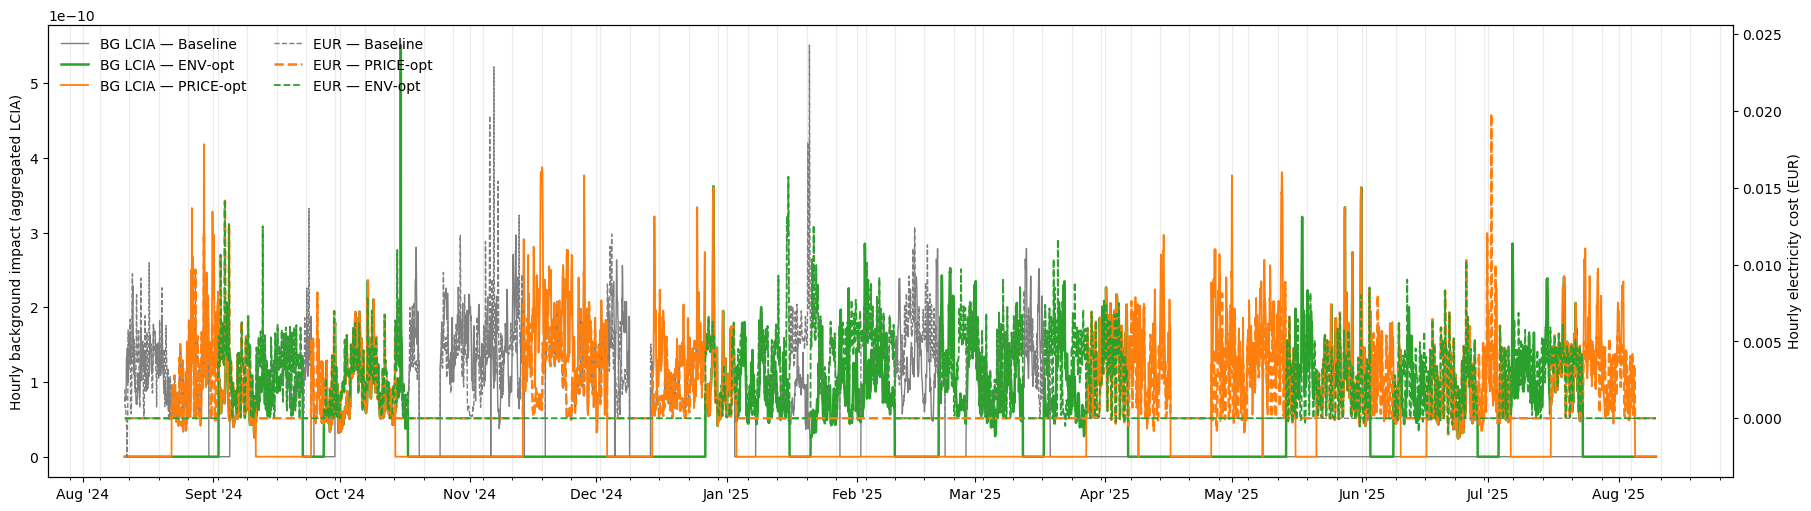

In [79]:
#  Hourly BG LCIA  vs EUR cost 

assert all(k in globals() for k in ['bg_base','bg_env','bg_pr','eur_base','eur_env','eur_pr','YEAR_IDX'])

def _style_time_axis(ax, xidx):
    span_days = max(1, (xidx[-1] - xidx[0]).days + 1)
    if   span_days >= 180:
        ax.xaxis.set_major_locator(mdates.MonthLocator()); ax.xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%b '%y"))
    elif span_days >= 60:
        ax.xaxis.set_major_locator(mdates.MonthLocator()); ax.xaxis.set_minor_locator(mdates.DayLocator(interval=7))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    elif span_days >= 14:
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO)); ax.xaxis.set_minor_locator(mdates.DayLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
    elif span_days >= 2:
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=1)); ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=[0,6,12,18]))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
    else:
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=6)); ax.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b %H:%M"))
    ax.grid(True, which='both', axis='x', alpha=0.25)

TIME = pd.DatetimeIndex(YEAR_IDX)
fig, axL = plt.subplots(figsize=(18, 5), constrained_layout=True)

# Left: BG LCIA
l_base,  = axL.plot(TIME, bg_base, lw=1.0, color=SC["base"],  label="BG LCIA — Baseline")
l_env,   = axL.plot(TIME, bg_env,  lw=1.8, color=SC["env"],   label="BG LCIA — ENV‑opt")
l_price, = axL.plot(TIME, bg_pr,   lw=1.3, color=SC["price"], label="BG LCIA — PRICE‑opt")
axL.set_ylabel("Hourly background impact (aggregated LCIA)")
_style_time_axis(axL, TIME)

# Right: EUR cost
axR = axL.twinx()
r_base,  = axR.plot(TIME, eur_base, lw=1.0, ls="--", color=SC["base"],  label="EUR — Baseline")
r_price, = axR.plot(TIME, eur_pr,   lw=1.8, ls="--", color=SC["price"], label="EUR — PRICE‑opt")
r_env,   = axR.plot(TIME, eur_env,  lw=1.3, ls="--", color=SC["env"],   label="EUR — ENV‑opt")
axR.set_ylabel("Hourly electricity cost (EUR)")

# Legend
handles = [l_base, l_env, l_price, r_base, r_price, r_env]
labels  = [h.get_label() for h in handles]
axL.legend(handles, labels, ncol=2, frameon=False, loc="upper left")

#axL.set_title("Hourly background LCIA vs electricity price — Baseline · ENV‑opt · PRICE‑opt")
#axL.set_xlabel("Calendar time ")


# SAVE 
OUT = Path(r"C:\Users\XXX\Figures")
OUT.mkdir(parents=True, exist_ok=True)

save_path = OUT / "LCIA_vs_price_FULLYEAR.png"   # filename 
fig.savefig(save_path, dpi=1200, bbox_inches="tight")   # DPI 


plt.show()

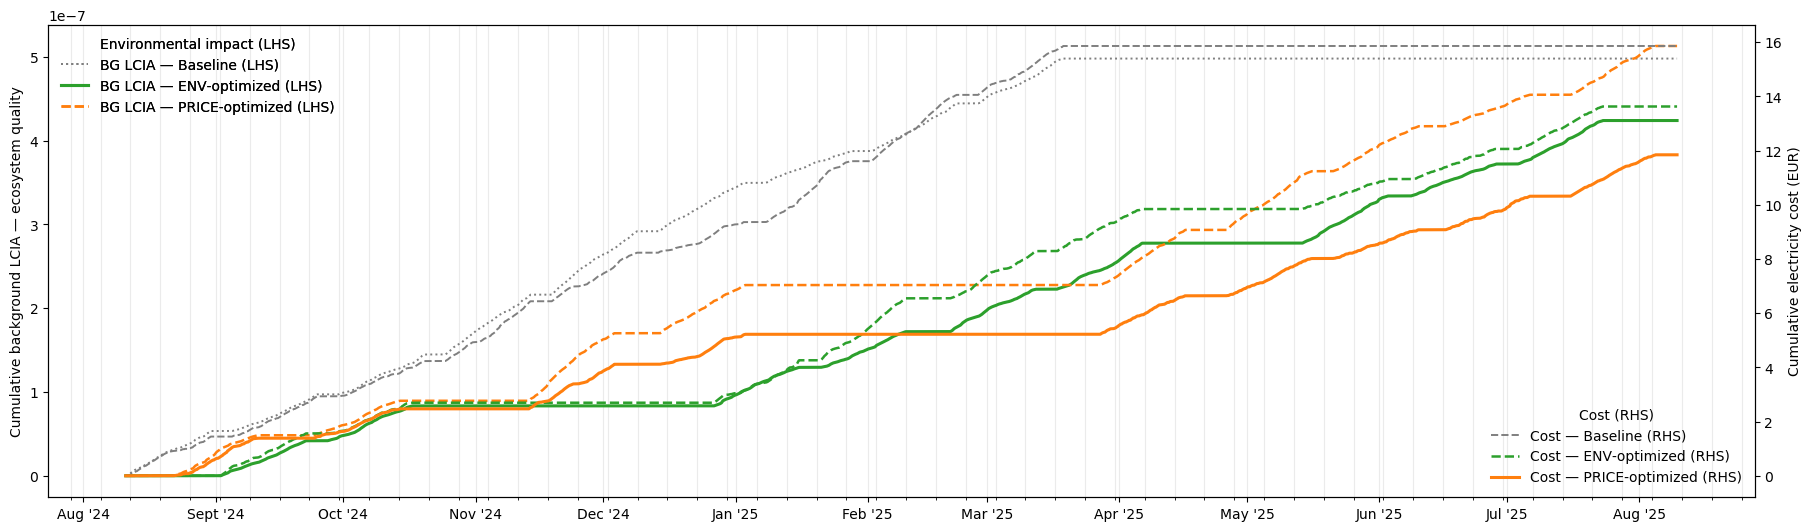

In [81]:
#  Cumulative BG and EUR 

# Inputs 
assert all(k in globals() for k in ['bg_base','bg_env','bg_pr','eur_base','eur_env','eur_pr','YEAR_IDX'])
TIME = pd.DatetimeIndex(YEAR_IDX)

SC = globals().get('SC', {"base":"#7f7f7f", "env":"#2ca02c", "price":"#ff7f0e"})

# Cumulative series
BGcum_base,  BGcum_env,  BGcum_pr  = np.cumsum(bg_base),  np.cumsum(bg_env),  np.cumsum(bg_pr)
EURcum_base, EURcum_env, EURcum_pr = np.cumsum(eur_base), np.cumsum(eur_env), np.cumsum(eur_pr)

def _style_time_axis(ax, xidx):
    span_days = max(1, (xidx[-1] - xidx[0]).days + 1)
    if   span_days >= 180:
        ax.xaxis.set_major_locator(mdates.MonthLocator()); ax.xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%b '%y"))
    elif span_days >= 60:
        ax.xaxis.set_major_locator(mdates.MonthLocator()); ax.xaxis.set_minor_locator(mdates.DayLocator(interval=7))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    elif span_days >= 14:
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO)); ax.xaxis.set_minor_locator(mdates.DayLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
    elif span_days >= 2:
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=1)); ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=[0,6,12,18]))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b"))
    else:
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=6)); ax.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b %H:%M"))
    ax.grid(True, which='both', axis='x', alpha=0.25)

fig, axL = plt.subplots(figsize=(18, 5.2), constrained_layout=True)
axR = axL.twinx()

#  cumulative environmental impact 
# Baseline = grey dotted
l_bg_base,  = axL.plot(TIME, BGcum_base,  color=SC["base"],  lw=1.4, ls=":",  label="BG LCIA — Baseline (LHS)")
# ENV‑optimized impact = green solid
l_bg_env,   = axL.plot(TIME, BGcum_env,   color=SC["env"],   lw=2.2, ls="-",  label="BG LCIA — ENV‑optimized (LHS)")
# PRICE‑optimized impact = orange dashed
l_bg_price, = axL.plot(TIME, BGcum_pr,    color=SC["price"], lw=1.8, ls="--", label="BG LCIA — PRICE‑optimized (LHS)")

axL.set_ylabel(("Cumulative background LCIA — " + str(globals().get("mk"))) if "mk" in globals() else "Cumulative background LCIA")
_style_time_axis(axL, TIME)

# cumulative electricity cost 
# Baseline = grey dashed
r_eur_base, = axR.plot(TIME, EURcum_base, color=SC["base"],  lw=1.4, ls="--", label="Cost — Baseline (RHS)")
# ENV‑optimized cost (side‑effect) = green dashed
r_eur_env,  = axR.plot(TIME, EURcum_env,  color=SC["env"],   lw=1.8, ls="--", label="Cost — ENV‑optimized (RHS)")
# PRICE‑optimized cost = orange solid
r_eur_price,= axR.plot(TIME, EURcum_pr,   color=SC["price"], lw=2.2, ls="-",  label="Cost — PRICE‑optimized (RHS)")

axR.set_ylabel("Cumulative electricity cost (EUR)")
#axL.set_title("Cumulative impact (LHS) and cost (RHS) — Baseline · ENV‑opt · PRICE‑opt")
#axL.set_xlabel("Calendar time (UTC)")

# Two concise legends, one per axis
leg_L = axL.legend(handles=[l_bg_base, l_bg_env, l_bg_price],
                   loc="upper left", frameon=False, title="Environmental impact (LHS)")
leg_R = axR.legend(handles=[r_eur_base, r_eur_env, r_eur_price],
                   loc="lower right", frameon=False, title="Cost (RHS)")
axL.add_artist(leg_L)

# Optional export
if 'OUT' in globals():
    base = "Cum_BG_EUR_axis_split_clear_styles"
    fig.savefig(OUT / f"{base}.pdf",  bbox_inches="tight")
    fig.savefig(OUT / f"{base}.png",  dpi=1200, bbox_inches="tight", facecolor="white")

plt.show()

Caption. Left axis plots cumulative background LCIA: grey dotted = baseline impact; green solid = environmental‑optimized impact; orange dashed = price‑optimized impact (side‑effect). Right axis plots cumulative electricity cost: grey dashed = baseline cost; green dashed = environmental‑optimized cost (side‑effect); orange solid = price‑optimized cost. Read impact on the left legend “Environmental impact (LHS)” and cost on the right legend “Cost (RHS)”.

 ## 10 Orthogonality test: ∇f vs ∇g in schedule space

=== Orthogonality test (finite differences, 1 h shifts) ===
          at         |∇f|     |∇g|     cos φ  |cos φ| ≤ 0.1?
  ENV-opt θ* 1.250185e-10 0.004386 -0.180032           False
PRICE-opt θ* 2.240833e-10 0.004924  0.157091           False

Per-cycle partial derivatives at ENV-opt:


schedule  cycle  start_idx            prod_start_utc  df_env/ds[h]  \
0  ENV-opt      1        536 2024-09-02 06:00:00+00:00 -3.377596e-11   
1  ENV-opt      2       1136 2024-09-27 06:00:00+00:00  1.836903e-11   
2  ENV-opt      3       3313 2024-12-26 23:00:00+00:00 -6.356911e-11   
3  ENV-opt      4       3913 2025-01-20 23:00:00+00:00  5.637280e-11   
4  ENV-opt      5       4644 2025-02-20 10:00:00+00:00 -4.408102e-11   
5  ENV-opt      6       5244 2025-03-17 10:00:00+00:00  3.018924e-11   
6  ENV-opt      7       6626 2025-05-14 00:00:00+00:00  3.335361e-11   
7  ENV-opt      8       7238 2025-06-08 12:00:00+00:00 -3.937272e-11   
8  ENV-opt      9       7838 2025-07-03 12:00:00+00:00  3.761993e-11   

   dg_price/ds[h]  
0       -0.001566  
1        0.001125  
2       -0.000239  
3       -0.002786  
4        0.000802  
5       -0.002269  
6        0.001003  
7       -0.000115  
8        0.000942


Per-cycle partial derivatives at PRICE-opt:


schedule  cycle  start_idx            prod_start_utc  df_env/ds[h]  \
0  PRICE-opt      1        268 2024-08-22 02:00:00+00:00 -4.112385e-11   
1  PRICE-opt      2       1064 2024-09-24 06:00:00+00:00 -8.767425e-11   
2  PRICE-opt      3       2272 2024-11-13 14:00:00+00:00 -9.679067e-11   
3  PRICE-opt      4       3010 2024-12-14 08:00:00+00:00 -7.519079e-11   
4  PRICE-opt      5       5486 2025-03-27 12:00:00+00:00  1.157938e-10   
5  PRICE-opt      6       6199 2025-04-26 05:00:00+00:00 -1.071246e-10   
6  PRICE-opt      7       6799 2025-05-21 05:00:00+00:00 -1.724813e-11   
7  PRICE-opt      8       7427 2025-06-16 09:00:00+00:00 -8.086881e-12   
8  PRICE-opt      9       8136 2025-07-15 22:00:00+00:00 -2.380146e-11   

   dg_price/ds[h]  
0        0.000334  
1        0.001085  
2        0.000272  
3        0.000248  
4        0.000754  
5       -0.001306  
6        0.000407  
7        0.000066  
8       -0.004513

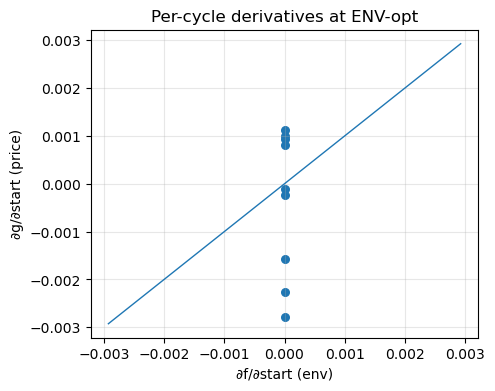

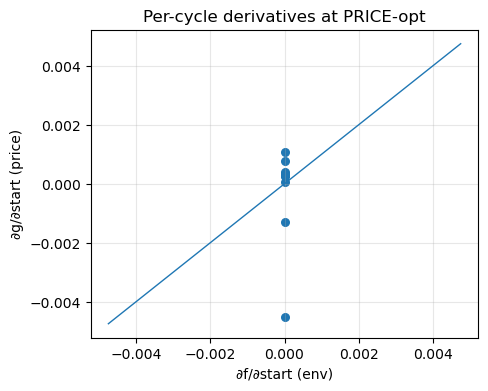

In [83]:
# f(θ) = total environmental objective (BG LCIA-weighted kWh placement)
# g(θ) = total price objective (EUR-weighted kWh placement)
# θ = vector of production start indices for the chosen schedule


assert 'YEAR_IDX' in globals() and isinstance(YEAR_IDX, (pd.Index, pd.DatetimeIndex))
assert 'block_kWh' in globals()
assert 'schedule_env_df' in globals() or 'schedule_cost_df' in globals()
schedule_price_df = globals().get('schedule_price_df', globals().get('schedule_cost_df'))

methods = list(LCIA_METHODS_RESOLVED.keys())
assert methods, "No LCIA methods resolved."

# Weighted per‑kWh environmental intensity across chosen methods 
if 'I_env_year' not in globals():
    WEIGHT_MK = {mk: 1.0 for mk in methods}
    w_sum = sum(max(0.0, float(WEIGHT_MK.get(mk, 0.0))) for mk in methods) or 1.0
    I_env_year = np.zeros(len(YEAR_IDX), dtype=float)
    for mk in methods:
        I_env_year += (float(WEIGHT_MK.get(mk, 0.0))/w_sum) * BG_INTENSITY_HOURLY[mk].reindex(YEAR_IDX)['Total'].to_numpy()

# Price per kWh (EUR/kWh) vector aligned to YEAR_IDX 
if 'price_per_kWh_year' not in globals():
    price_per_kWh_year = pd.to_numeric(price_utc, errors='coerce').reindex(YEAR_IDX).ffill().bfill().to_numpy()/1000.0

# Basic schedule dimensions 
P = int(globals().get('MAX_BLOCK_HOURS', 0)); C = int(globals().get('CIP_HOURS', 0)); L = P + C
assert P > 0 and L > 0, "Bad P/C/L."

# Precompute convolution costs per candidate start for environment and price
def window_costs(cost_per_kWh_year: np.ndarray, block_kWh: np.ndarray) -> np.ndarray:
    """Cost of placing a P-hour production block starting at each start s (ignoring CIP, which has 0 kWh)."""
    N = len(cost_per_kWh_year); assert len(block_kWh) == P
    if N < P: raise RuntimeError("Time axis shorter than block length.")
    W = sliding_window_view(cost_per_kWh_year, window_shape=P)     # [N-P+1, P]
    return W @ block_kWh                                          # [N-P+1]

COST_ENV_FULL = window_costs(I_env_year, block_kWh)               # shape [N-P+1]
COST_EUR_FULL = window_costs(price_per_kWh_year, block_kWh)       # shape [N-P+1]
N = len(YEAR_IDX); M_full = len(COST_ENV_FULL)

# Map datetime → index
pos_map = pd.Series(np.arange(N), index=pd.DatetimeIndex(YEAR_IDX))

def extract_full_starts(schedule_df: pd.DataFrame) -> np.ndarray:
    """Return sorted integer starts (positions) for 'full' cycles only."""
    if schedule_df is None or schedule_df.empty: return np.array([], dtype=int)
    df = schedule_df.copy()
    df = df[df['type'].isin(['full'])] if 'type' in df.columns else df
    s = df['prod_start'].apply(lambda t: int(pos_map.get(pd.to_datetime(t))))
    s = s.dropna().astype(int).to_numpy()
    return np.sort(s)

def finite_diff_grad(cost_full: np.ndarray, starts: np.ndarray, L: int) -> np.ndarray:
    """
    ∂J/∂s_i via one-hour finite differences, keeping non-overlap:
    try +1 if (s_i+1) ≤ (s_{i+1} - L); else try -1 if (s_{i-1}+L) ≤ (s_i-1); else NaN.
    """
    g = np.full_like(starts, np.nan, dtype=float)
    for k, s in enumerate(starts):
        # forward feasible?
        fwd_ok = (s+1) < (starts[k+1] - L) if (k+1) < len(starts) else ((s+1) <= (N - L))
        # backward feasible?
        bwd_ok = (starts[k-1] + L) <= (s-1) if k > 0 else (s-1) >= 0
        if fwd_ok and (s+1) < len(cost_full):
            g[k] = float(cost_full[s+1] - cost_full[s])
        elif bwd_ok and (s-1) >= 0:
            g[k] = float(cost_full[s] - cost_full[s-1])
        # else remain NaN (unperturbable at 1 h without overlap)
    return g

# Compute gradients at the ENV-opt schedule point θ_env
starts_env = extract_full_starts(globals().get('schedule_env_df'))
grad_f_env = finite_diff_grad(COST_ENV_FULL, starts_env, L=L)   # ∇f at θ_env
grad_g_env = finite_diff_grad(COST_EUR_FULL, starts_env, L=L)   # ∇g at θ_env

# Compute gradients at the PRICE-opt schedule point θ_price
starts_pr  = extract_full_starts(schedule_price_df)
grad_f_pr  = finite_diff_grad(COST_ENV_FULL, starts_pr,  L=L)   # ∇f at θ_price
grad_g_pr  = finite_diff_grad(COST_EUR_FULL, starts_pr,  L=L)   # ∇g at θ_price

def cos_angle(a: np.ndarray, b: np.ndarray) -> float:
    m = np.isfinite(a) & np.isfinite(b)
    if m.sum() == 0: return np.nan
    a2 = a[m]; b2 = b[m]
    na = float(np.linalg.norm(a2)); nb = float(np.linalg.norm(b2))
    if na == 0.0 or nb == 0.0: return np.nan
    return float(np.dot(a2, b2) / (na * nb))

cos_env = cos_angle(grad_f_env, grad_g_env)
cos_pr  = cos_angle(grad_f_pr,  grad_g_pr)

# Pack results as small tables
def build_grad_table(starts, g_f, g_g, label):
    rows = []
    for k, s in enumerate(starts):
        ts = YEAR_IDX[min(s, len(YEAR_IDX)-1)]
        rows.append({"schedule":label, "cycle":k+1, "start_idx":int(s),
                     "prod_start_utc": pd.to_datetime(ts), "df_env/ds[h]": g_f[k], "dg_price/ds[h]": g_g[k]})
    return pd.DataFrame(rows)

TAB_env = build_grad_table(starts_env, grad_f_env, grad_g_env, "ENV-opt")
TAB_pr  = build_grad_table(starts_pr,  grad_f_pr,  grad_g_pr,  "PRICE-opt")

OUT_ortho = pd.DataFrame([
    {"at":"ENV-opt θ*",   "|∇f|": float(np.nan if not np.isfinite(grad_f_env).any() else np.linalg.norm(np.nan_to_num(grad_f_env))),
     "|∇g|": float(np.nan if not np.isfinite(grad_g_env).any() else np.linalg.norm(np.nan_to_num(grad_g_env))),
     "cos φ": cos_env, "|cos φ| ≤ 0.1?": (abs(cos_env) <= 0.1) if np.isfinite(cos_env) else None},
    {"at":"PRICE-opt θ*", "|∇f|": float(np.nan if not np.isfinite(grad_f_pr).any() else np.linalg.norm(np.nan_to_num(grad_f_pr))),
     "|∇g|": float(np.nan if not np.isfinite(grad_g_pr).any() else np.linalg.norm(np.nan_to_num(grad_g_pr))),
     "cos φ": cos_pr,  "|cos φ| ≤ 0.1?": (abs(cos_pr) <= 0.1) if np.isfinite(cos_pr) else None},
])

print("=== Orthogonality test (finite differences, 1 h shifts) ===")
print(OUT_ortho.to_string(index=False))

print("\nPer-cycle partial derivatives at ENV-opt:")
display(TAB_env)

print("\nPer-cycle partial derivatives at PRICE-opt:")
display(TAB_pr)

#  plot

def scatter_grad(x, y, title):
    m = np.isfinite(x) & np.isfinite(y)
    if m.sum() == 0: 
        print("No feasible 1 h perturbations for scatter.")
        return
    plt.figure(figsize=(5,4))
    plt.scatter(x[m], y[m], s=30)
    lim = np.nanmax(np.abs(np.concatenate([x[m], y[m]]))); lim = 1.05*lim if np.isfinite(lim) else 1.0
    plt.plot([-lim, lim], [-lim, lim], lw=1)
    plt.xlabel("∂f/∂start (env)"); plt.ylabel("∂g/∂start (price)")
    plt.title(title); plt.grid(True, alpha=0.3); plt.show()

scatter_grad(grad_f_env, grad_g_env, "Per-cycle derivatives at ENV-opt")
scatter_grad(grad_f_pr,  grad_g_pr,  "Per-cycle derivatives at PRICE-opt")

In [84]:
def kwh_year_from_baseline() -> np.ndarray:
    """
    Contiguous baseline plan of length YEAR_HOURS:
    place K full (P+C) cycles plus remainder production, starting at CIP_START_OFFSET_H.
    Returns E(t) with length len(YEAR_IDX).
    """
    idx = pd.DatetimeIndex(YEAR_IDX)
    N = len(idx)
    P_loc = int(P)
    C_loc = int(C)
    L_loc = P_loc + C_loc
    assert P_loc > 0 and L_loc > 0 and len(block_kWh) >= P_loc, "Bad P/C or block_kWh."

    total_sched = int(globals().get('YEAR_HOURS', N))  # hours of baseline schedule to allocate
    K_loc, R_loc = divmod(total_sched, L_loc)
    P_rem_loc = min(R_loc, P_loc)
    off = int(globals().get('CIP_START_OFFSET_H', 0)) % L_loc

    E = np.zeros(N, dtype=float)

    # place K full production segments separated by L_loc
    t = off
    for _ in range(K_loc):
        if t >= N:
            break
        e = min(t + P_loc, N)
        if e > t:
            E[t:e] += block_kWh[:(e - t)]
        t += L_loc

    # place remainder production 
    if P_rem_loc > 0 and t < N:
        e = min(t + P_rem_loc, N)
        if e > t:
            E[t:e] += block_kWh[:(e - t)]

    return E


In [85]:
E_base  = kwh_year_from_baseline()
E_env   = kwh_year_from_schedule(globals().get('schedule_env_df'))
E_price = kwh_year_from_schedule(globals().get('schedule_cost_df'))

I_year  = I_env_year.copy()
P_raw   = pd.to_numeric(price_utc, errors='coerce').reindex(YEAR_IDX).ffill().bfill().to_numpy()

In [87]:
# 12 — Sobol(main) index S_P for price on Y(t) = E(t) * I(t); plus orthogonalized S_{P^⊥}
# E(t): plant kWh profile induced by schedule; I(t): per‑kWh LCIA intensity from ENTSO‑E mix.
# P(t): day-ahead price; P^⊥ = residual of OLS regression of P on (E, I).

assert 'block_kWh' in globals() and len(block_kWh) == P

def kwh_year_from_schedule(schedule_df: pd.DataFrame) -> np.ndarray:
    """Return length-N array E(t) for the year; sum of placed 'block_kWh' across all scheduled prod windows."""
    N = len(YEAR_IDX)
    E = np.zeros(N, dtype=float)
    if schedule_df is None or schedule_df.empty:
        return E
    pos = pd.Series(np.arange(N), index=pd.DatetimeIndex(YEAR_IDX))
    for r in schedule_df.itertuples(index=False):
        s = int(pos.get(pd.to_datetime(r.prod_start)))
        ph = int(getattr(r, 'prod_hours', P))
        ph = min(ph, P)
        e_end = min(s + ph, N)
        k_end = ph - max(0, (s+ph) - N)
        if k_end > 0 and s < N:
            E[s:e_end] += block_kWh[:k_end]
    return E

# Baseline contiguous plan 
def kwh_year_from_baseline() -> np.ndarray:
    """
    Contiguous baseline plan of length YEAR_HOURS:
    place K full (P+C) cycles plus remainder production, starting at CIP_START_OFFSET_H.
    Returns E(t) with length len(YEAR_IDX).
    """
    idx = pd.DatetimeIndex(YEAR_IDX)
    N = len(idx)
    P_loc = int(P)
    C_loc = int(C)
    L_loc = P_loc + C_loc
    assert P_loc > 0 and L_loc > 0 and len(block_kWh) >= P_loc, "Bad P/C or block_kWh."

    total_sched = int(globals().get('YEAR_HOURS', N))  # hours of baseline schedule to allocate
    K_loc, R_loc = divmod(total_sched, L_loc)
    P_rem_loc = min(R_loc, P_loc)
    off = int(globals().get('CIP_START_OFFSET_H', 0)) % L_loc

    E = np.zeros(N, dtype=float)

    # place K full production segments separated
    t = off
    for _ in range(K_loc):
        if t >= N:
            break
        e = min(t + P_loc, N)
        if e > t:
            E[t:e] += block_kWh[:(e - t)]
        t += L_loc

    # place remainder production 
    if P_rem_loc > 0 and t < N:
        e = min(t + P_rem_loc, N)
        if e > t:
            E[t:e] += block_kWh[:(e - t)]

    return E


# Choose which schedule to test S_P on; baseline ("no price scheduling")
E_base  = kwh_year_from_baseline()
E_env   = kwh_year_from_schedule(globals().get('schedule_env_df'))
E_price = kwh_year_from_schedule(globals().get('schedule_cost_df'))

# Per‑hour intensity 
I_year = I_env_year.copy()

#  price signal 
P_raw = pd.to_numeric(price_utc, errors='coerce').reindex(YEAR_IDX).ffill().bfill().to_numpy()  # EUR/MWh

def sobol_main_binned(x: np.ndarray, y: np.ndarray, bins: int = 12, boot: int = 400, seed: int = 0):
    """
    Estimate S = Var_X{ E[Y|X] } / Var(Y) via binning + bootstrap CI.
    x: driver (price), y: response (Y=E*I).
    Returns: S_hat, (lo, hi), cond_table with bin stats.
    """
    assert len(x) == len(y)
    msk = np.isfinite(x) & np.isfinite(y)
    x = x[msk]; y = y[msk]
    if np.allclose(np.var(y), 0.0): 
        return np.nan, (np.nan, np.nan), pd.DataFrame()
    q = np.quantile(x, np.linspace(0, 1, bins+1))
    # Enforce unique edges
    q = np.unique(q)
    if len(q) < 3:
        return np.nan, (np.nan, np.nan), pd.DataFrame()
    lab = np.digitize(x, q[1:-1], right=False)
    df = pd.DataFrame({"x":x, "y":y, "bin":lab})
    grp = df.groupby("bin", dropna=False)
    mu = grp["y"].mean(); p  = grp["y"].count() / len(df)
    mu_global = float(df["y"].mean()); var_global = float(df["y"].var(ddof=0))
    var_cond = float(np.sum(p.to_numpy() * (mu.to_numpy() - mu_global)**2))
    S_hat = var_cond / var_global

    # bootstrap CI
    rng = np.random.default_rng(seed)
    boot_vals = []
    for _ in range(int(boot)):
        idx = rng.integers(0, len(df), len(df))
        d2 = df.iloc[idx]
        g2 = d2.groupby("bin", dropna=False)
        mu2 = g2["y"].mean(); p2 = g2["y"].count() / len(d2)
        mu_g = float(d2["y"].mean()); var_g = float(d2["y"].var(ddof=0))
        if var_g <= 0: 
            continue
        # align by bin index
        bins_all = np.union1d(mu.index.to_numpy(), mu2.index.to_numpy())
        mu2a = mu2.reindex(bins_all).fillna(mu_g)
        p2a  = p2.reindex(bins_all).fillna(0.0)
        boot_vals.append( float(np.sum(p2a.to_numpy() * (mu2a.to_numpy() - mu_g)**2)) / var_g )
    lo, hi = (np.nan, np.nan) if not boot_vals else (np.quantile(boot_vals, 0.025), np.quantile(boot_vals, 0.975))

    # conditional table for plotting
    cond = pd.DataFrame({
        "bin": mu.index.to_numpy(),
        "x_low": q[:-1][:len(mu)],
        "x_high": q[1:][:len(mu)],
        "x_mid": 0.5*(q[:-1][:len(mu)] + q[1:][:len(mu)]),
        "p_bin": p.reindex(mu.index).to_numpy(),
        "E[Y|bin]": mu.to_numpy()
    })
    return S_hat, (lo, hi), cond

def ols_residual(y, X):
    """Return residuals of y ~ [1, X]."""
    Xd = np.column_stack([np.ones(len(y)), X])
    beta, *_ = np.linalg.lstsq(Xd, y, rcond=None)
    return (y - Xd @ beta), beta

def sobol_report(E, label, bins=12, boot=400):
    Y = E * I_year
    S, CI, cond = sobol_main_binned(P_raw, Y, bins=bins, boot=boot, seed=1)
    # Orthogonalize price vs E and I to remove incidental correlation
    R, beta = ols_residual(P_raw, np.column_stack([E, I_year]))
    S_perp, CI_perp, cond_perp = sobol_main_binned(R, Y, bins=bins, boot=boot, seed=2)

    print(f"\n=== Sobol(main) of price on Y=E·I  — scenario: {label} ===")
    print(f"S_P = {S:.4g}   95% CI ~ [{CI[0]:.4g}, {CI[1]:.4g}]")
    print(f"S_P_perp (price residual vs E,I) = {S_perp:.4g}   95% CI ~ [{CI_perp[0]:.4g}, {CI_perp[1]:.4g}]")

    # Plot conditional expectation vs price bins
    if not cond.empty:
        plt.figure(figsize=(6,3.4))
        plt.plot(cond["x_mid"], cond["E[Y|bin]"], marker='o', lw=1.5)
        plt.xlabel("Day‑ahead price (EUR/MWh) — bin mid")
        plt.ylabel("E[Y | price bin]")
        plt.title(f"E[Y|P] (scenario: {label})"); plt.grid(True, alpha=0.3); plt.show()

    if not cond_perp.empty:
        plt.figure(figsize=(6,3.4))
        plt.plot(cond_perp["x_mid"], cond_perp["E[Y|bin]"], marker='o', lw=1.5)
        plt.xlabel("Residual price P^⊥ — bin mid")
        plt.ylabel("E[Y | residual bin]")
        plt.title(f"E[Y|P^⊥] (scenario: {label})"); plt.grid(True, alpha=0.3); plt.show()

    return {"scenario":label, "S_P":S, "S_P_lo":CI[0], "S_P_hi":CI[1],
            "S_P_perp":S_perp, "S_P_perp_lo":CI_perp[0], "S_P_perp_hi":CI_perp[1]}

# Run for baseline 
rows = []
rows.append(sobol_report(E_base,  "Baseline (contiguous)"))
if np.any(E_env   > 0): rows.append(sobol_report(E_env,   "ENV‑optimized"))
if np.any(E_price > 0): rows.append(sobol_report(E_price, "PRICE‑optimized"))

SOBOL_SUMMARY = pd.DataFrame(rows)
print("\nSobol summary:")
display(SOBOL_SUMMARY)


=== Sobol(main) of price on Y=E·I  — scenario: Baseline (contiguous) ===
S_P = nan   95% CI ~ [nan, nan]
S_P_perp (price residual vs E,I) = nan   95% CI ~ [nan, nan]

=== Sobol(main) of price on Y=E·I  — scenario: ENV‑optimized ===
S_P = nan   95% CI ~ [nan, nan]
S_P_perp (price residual vs E,I) = nan   95% CI ~ [nan, nan]

=== Sobol(main) of price on Y=E·I  — scenario: PRICE‑optimized ===
S_P = nan   95% CI ~ [nan, nan]
S_P_perp (price residual vs E,I) = nan   95% CI ~ [nan, nan]

Sobol summary:


scenario  S_P  S_P_lo  S_P_hi  S_P_perp  S_P_perp_lo  \
0  Baseline (contiguous)  NaN     NaN     NaN       NaN          NaN   
1          ENV‑optimized  NaN     NaN     NaN       NaN          NaN   
2        PRICE‑optimized  NaN     NaN     NaN       NaN          NaN   

   S_P_perp_hi  
0          NaN  
1          NaN  
2          NaN

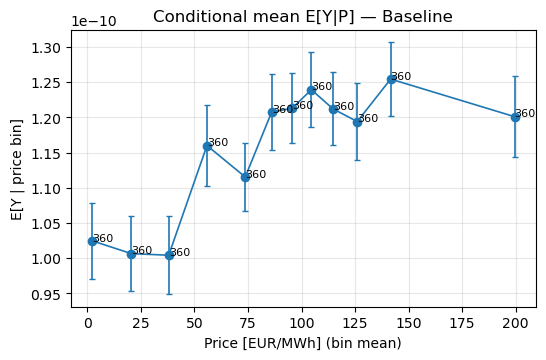

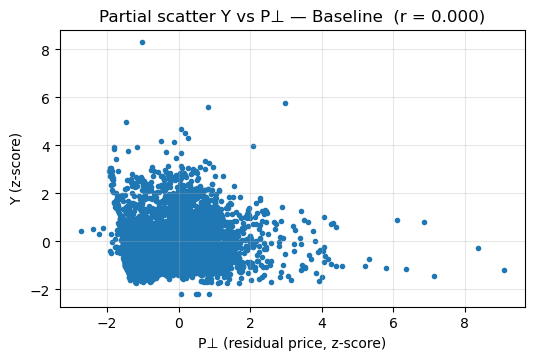

Baseline: partial correlation r(Y, P⊥) = 0.0001


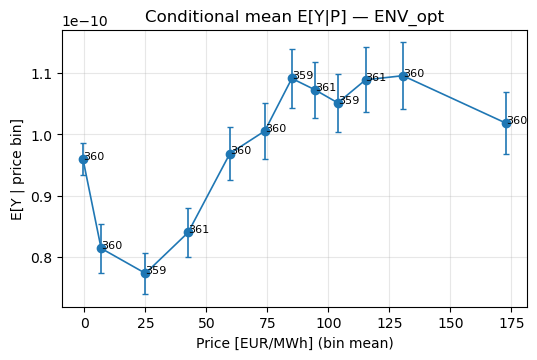

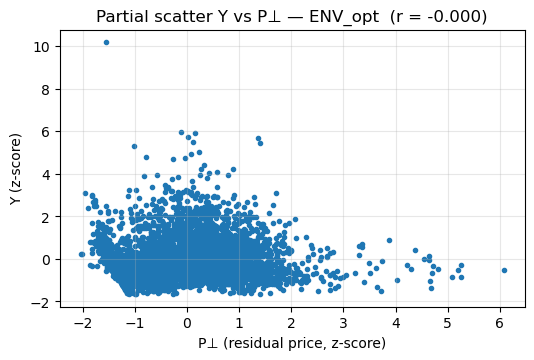

ENV_opt: partial correlation r(Y, P⊥) = -0.0001


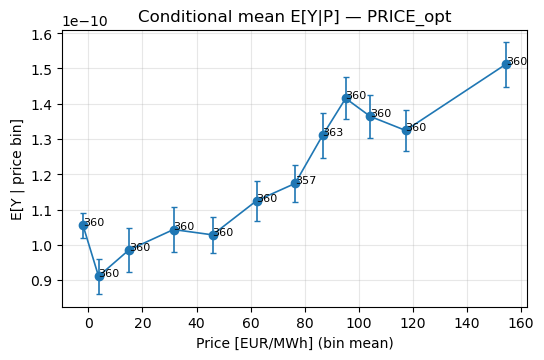

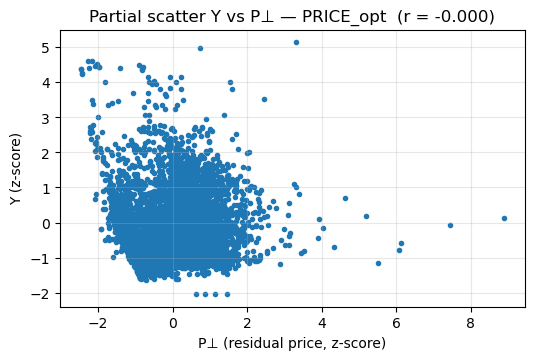

PRICE_opt: partial correlation r(Y, P⊥) = -0.0001


In [88]:
#  SAVE 
OUT = Path(r"C:\Users\XXX\MC_Sobol")
OUT.mkdir(parents=True, exist_ok=True)

def save_current_figure(name, dpi=600):
    """Save current figure in PNG + PDF at chosen DPI."""
    plt.savefig(OUT / f"{name}.png", dpi=dpi, bbox_inches="tight", facecolor="white")
    plt.savefig(OUT / f"{name}.pdf", dpi=dpi, bbox_inches="tight", facecolor="white")

def _active_mask(E):
    m = np.isfinite(E) & (E > 0)
    return m

def _quantile_bins(x, bins):
    q = np.quantile(x, np.linspace(0, 1, bins + 1))
    q = np.unique(q)
    if len(q) < 3:
        return None, None
    lab = np.digitize(x, q[1:-1], right=False)
    return lab, q

# CONDITIONAL MEAN 

def plot_conditional_mean(E, I, P, bins=12, label="scenario"):
    """Plot E[Y|P] with sample counts and 95% normal CIs per bin and SAVE."""
    m = _active_mask(E)
    Y = (E[m] * I[m]).astype(float)
    Pm = P[m].astype(float)

    uniq = np.unique(Pm)
    eff_bins = int(max(2, min(bins, len(uniq)-1, int(np.sqrt(len(Pm))))))
    lab, edges = _quantile_bins(Pm, eff_bins)
    if lab is None:
        print(f"{label}: not enough unique prices to bin.")
        return

    df = pd.DataFrame({"P": Pm, "Y": Y, "bin": lab})
    g = df.groupby("bin", observed=True)

    x_mean = g["P"].mean()
    y_mean = g["Y"].mean()
    n = g.size()
    y_std = g["Y"].std(ddof=1)
    y_sem = y_std / np.sqrt(n.clip(lower=1))
    y_lo = y_mean - 1.96 * y_sem
    y_hi = y_mean + 1.96 * y_sem

    plt.figure(figsize=(6, 3.6))
    plt.errorbar(x_mean.values, y_mean.values,
                 yerr=[(y_mean - y_lo).values, (y_hi - y_mean).values],
                 fmt='o-', capsize=2, linewidth=1.2)
    for xm, ym, ni in zip(x_mean.values, y_mean.values, n.values):
        plt.annotate(str(int(ni)), (xm, ym), fontsize=8)

    plt.xlabel("Price [EUR/MWh] (bin mean)")
    plt.ylabel("E[Y | price bin]")
    plt.title(f"Conditional mean E[Y|P] — {label}")
    plt.grid(True, which='both', axis='both', alpha=0.3)

    # SAVE
    save_current_figure(f"conditional_mean_{label}", dpi=600)
    plt.show()

def plot_partial_scatter(E, I, P, label="scenario"):
    """Scatter of standardized Y vs standardized residual price P⊥ after OLS P~E+I."""
    m = _active_mask(E)
    Y = (E[m] * I[m]).astype(float)
    X = np.column_stack([np.ones(m.sum()), E[m].astype(float), I[m].astype(float)])
    beta, *_ = lstsq(X, P[m].astype(float), rcond=None)
    P_perp = P[m].astype(float) - X @ beta

    # z-score
    z = lambda a: (a - np.mean(a)) / (np.std(a) if np.std(a) > 0 else 1.0)
    Yz = z(Y); Pz = z(P_perp)

    r = float(np.corrcoef(Pz, Yz)[0, 1])

    plt.figure(figsize=(6, 3.6))
    plt.scatter(Pz, Yz, s=9)
    plt.xlabel("P⊥ (residual price, z-score)")
    plt.ylabel("Y (z-score)")
    plt.title(f"Partial scatter Y vs P⊥ — {label}  (r = {r:.3f})")
    plt.grid(True, which='both', axis='both', alpha=0.3)

    # SAVE
    save_current_figure(f"partial_scatter_{label}", dpi=600)
    plt.show()

    print(f"{label}: partial correlation r(Y, P⊥) = {r:.4f}")

# RUN 

plot_conditional_mean(E_base,  I_year, P_raw, bins=12, label="Baseline")
plot_partial_scatter(E_base,   I_year, P_raw,            label="Baseline")

plot_conditional_mean(E_env,   I_year, P_raw, bins=12, label="ENV_opt")
plot_partial_scatter(E_env,    I_year, P_raw,            label="ENV_opt")

plot_conditional_mean(E_price, I_year, P_raw, bins=12, label="PRICE_opt")
plot_partial_scatter(E_price,  I_year, P_raw,            label="PRICE_opt")
